# The weather dataset
This tutorial uses a [weather time series dataset recorded by the Max Planck Institute for Biogeochemistry.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.

https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
%load_ext tensorboard


In [2]:
import tensorflow as tf
import datetime

from lstm_timeseries import (data_proc, 
                             univariate_data, 
                             show_plot, 
                             baseline, 
                             multivariate_data,
                             single_step_model, 
                             TimeSeriesLSTM, 
                             plot_preds, 
                             train_val_tf)

import matplotlib.pyplot as plt
tf.random.set_seed(13)



In [3]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [4]:
%%time
df = data_proc()

Wall time: 1.17 s


In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
TRAIN_SPLIT = 300000


# Part 1: Forecast a univariate time series

In [7]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

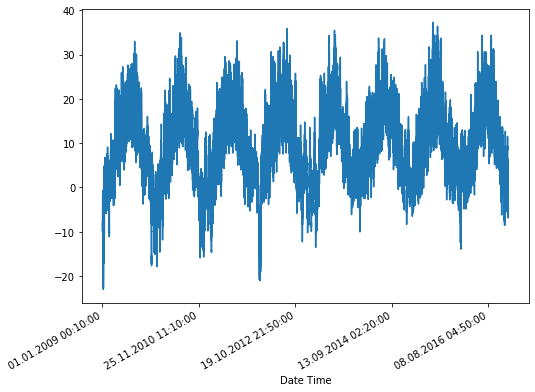

In [8]:
uni_data.plot(subplots=True);

In [9]:
uni_data = uni_data.values

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std


univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

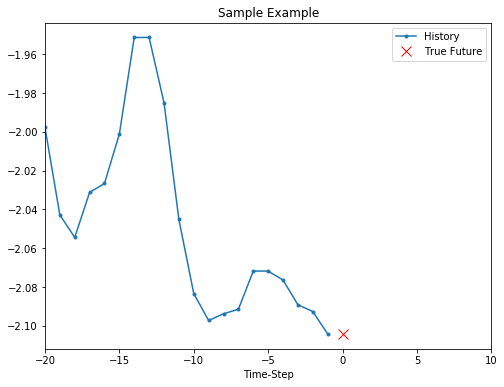

In [10]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example');

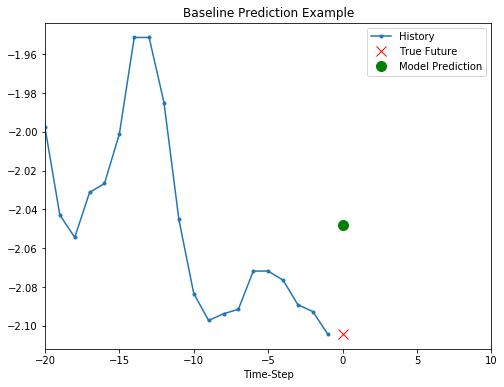

In [11]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example');

# Multivariate forecast with lstm

In [12]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


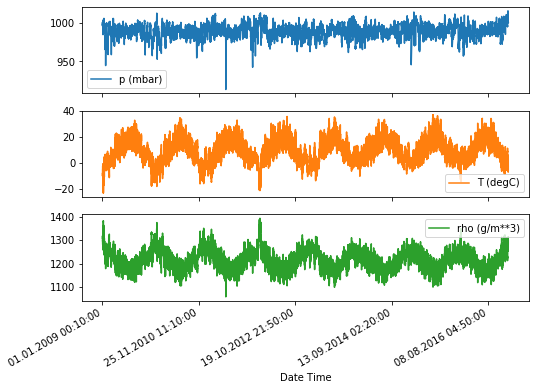

In [13]:
features.plot(subplots=True);

In [14]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset - data_mean)/data_std

# Single step model
* multivariate features to predict next time step

In [15]:
# data for the last 5 days is used (720 observations) predict 12h ahead
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)



In [16]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [17]:
%%time
trained_model, single_step_history = single_step_model(x_train_single, 
                                                       y_train_single,
                                                       x_val_single, 
                                                       y_val_single,
                                                       epochs=3)



Train for 200 steps, validate for 50 steps
Epoch 1/3
200/200 [==============================] - ETA: 13:54 - loss: 1.13 - ETA: 2:17 - loss: 0.9627 - ETA: 1:13 - loss: 0.795 - ETA: 50s - loss: 0.663 - ETA: 37s - loss: 0.59 - ETA: 28s - loss: 0.54 - ETA: 22s - loss: 0.51 - ETA: 18s - loss: 0.49 - ETA: 15s - loss: 0.47 - ETA: 13s - loss: 0.45 - ETA: 11s - loss: 0.44 - ETA: 10s - loss: 0.43 - ETA: 9s - loss: 0.4230 - ETA: 8s - loss: 0.412 - ETA: 7s - loss: 0.403 - ETA: 6s - loss: 0.394 - ETA: 5s - loss: 0.386 - ETA: 5s - loss: 0.379 - ETA: 4s - loss: 0.373 - ETA: 4s - loss: 0.367 - ETA: 3s - loss: 0.362 - ETA: 3s - loss: 0.359 - ETA: 3s - loss: 0.356 - ETA: 2s - loss: 0.353 - ETA: 2s - loss: 0.349 - ETA: 2s - loss: 0.345 - ETA: 1s - loss: 0.341 - ETA: 1s - loss: 0.338 - ETA: 1s - loss: 0.336 - ETA: 1s - loss: 0.334 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.331 - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.325 - 7s 35ms/step - loss: 0.3251 - val_loss: 0.2670
Epoch 2/

# Plot first 3 predictions
Use validation data for predictions

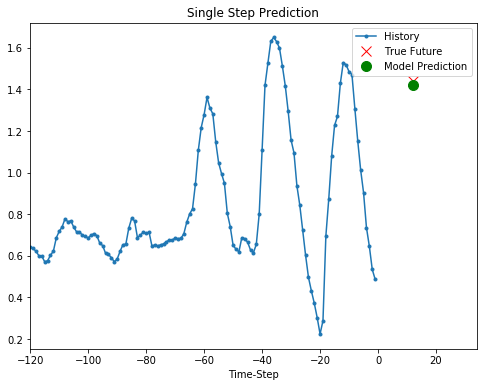

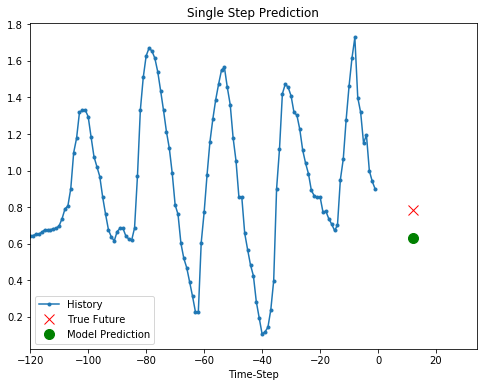

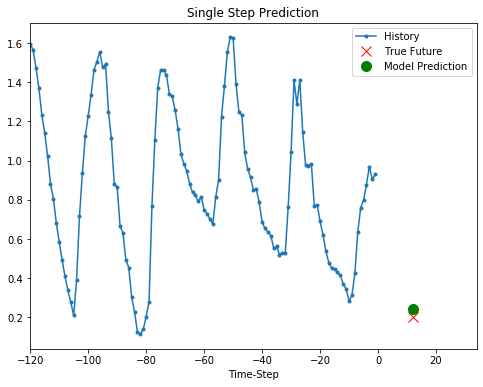

In [18]:

train_data_single, val_data_single = train_val_tf(x_train_single, y_train_single, x_val_single, y_val_single)
plot_preds(trained_model, val_data_single)



In [19]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

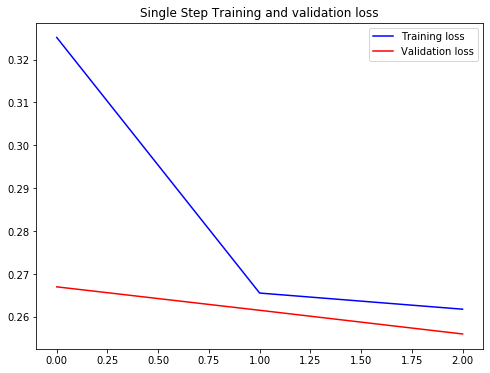

In [20]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

# Hyperparam search
### Hyperband
* Same data as in single step training above

In [21]:
%%time
from kerastuner.tuners import RandomSearch, Hyperband


log_dir = "logs\hyperband" #+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)
print("log_dir", log_dir)



hypermodel = TimeSeriesLSTM(num_outputs=1)
    
tuner = Hyperband(
    hypermodel,
    objective='mae',
    directory=log_dir,
    project_name='helloworld_hyperband', 
    max_epochs=3
)



tuner.search(x_train_single,
             y_train_single, 
             epochs=3, 
             validation_data=(x_val_single, y_val_single), 
             callbacks=[tensorboard_callback])

log_dir logs\hyperband
Train on 299280 samples, validate on 119759 samples


 32256/299280 [==>...........................] - ETA: 5:30:46 - loss: 0.6144 - mae: 0.61 - ETA: 2:49:48 - loss: 0.4771 - mae: 0.47 - ETA: 57:56 - loss: 0.4154 - mae: 0.4154 - ETA: 32:25 - loss: 0.3891 - mae: 0.38 - ETA: 22:51 - loss: 0.3734 - mae: 0.37 - ETA: 17:49 - loss: 0.3673 - mae: 0.36 - ETA: 14:42 - loss: 0.3601 - mae: 0.36 - ETA: 12:35 - loss: 0.3501 - mae: 0.35 - ETA: 11:03 - loss: 0.3487 - mae: 0.34 - ETA: 9:54 - loss: 0.3467 - mae: 0.3467 - ETA: 8:59 - loss: 0.3416 - mae: 0.341 - ETA: 8:16 - loss: 0.3379 - mae: 0.337 - ETA: 7:40 - loss: 0.3365 - mae: 0.336 - ETA: 7:10 - loss: 0.3359 - mae: 0.335 - ETA: 6:45 - loss: 0.3316 - mae: 0.331 - ETA: 6:23 - loss: 0.3309 - mae: 0.330 - ETA: 6:04 - loss: 0.3306 - mae: 0.330 - ETA: 5:47 - loss: 0.3302 - mae: 0.330 - ETA: 5:33 - loss: 0.3276 - mae: 0.327 - ETA: 5:20 - loss: 0.3249 - mae: 0.324 - ETA: 5:08 - loss: 0.3240 - mae: 0.324 - ETA: 4:58 - loss: 0.3230 - mae: 0.323 - ETA: 4:49 - loss: 0.3209 - mae: 0.320 - ETA: 4:40 - loss: 0.3191

 64864/299280 [=====>........................] - ETA: 1:47 - loss: 0.2770 - mae: 0.277 - ETA: 1:47 - loss: 0.2770 - mae: 0.277 - ETA: 1:47 - loss: 0.2769 - mae: 0.276 - ETA: 1:47 - loss: 0.2769 - mae: 0.276 - ETA: 1:47 - loss: 0.2768 - mae: 0.276 - ETA: 1:47 - loss: 0.2767 - mae: 0.276 - ETA: 1:46 - loss: 0.2769 - mae: 0.276 - ETA: 1:46 - loss: 0.2767 - mae: 0.276 - ETA: 1:46 - loss: 0.2766 - mae: 0.276 - ETA: 1:46 - loss: 0.2765 - mae: 0.276 - ETA: 1:46 - loss: 0.2765 - mae: 0.276 - ETA: 1:46 - loss: 0.2764 - mae: 0.276 - ETA: 1:46 - loss: 0.2764 - mae: 0.276 - ETA: 1:46 - loss: 0.2764 - mae: 0.276 - ETA: 1:45 - loss: 0.2764 - mae: 0.276 - ETA: 1:45 - loss: 0.2765 - mae: 0.276 - ETA: 1:45 - loss: 0.2765 - mae: 0.276 - ETA: 1:45 - loss: 0.2764 - mae: 0.276 - ETA: 1:45 - loss: 0.2763 - mae: 0.276 - ETA: 1:45 - loss: 0.2763 - mae: 0.276 - ETA: 1:45 - loss: 0.2763 - mae: 0.276 - ETA: 1:44 - loss: 0.2762 - mae: 0.276 - ETA: 1:44 - loss: 0.2761 - mae: 0.276 - ETA: 1:44 - loss: 0.2760 - mae:

 97280/299280 [========>.....................] - ETA: 1:28 - loss: 0.2684 - mae: 0.268 - ETA: 1:28 - loss: 0.2683 - mae: 0.268 - ETA: 1:27 - loss: 0.2683 - mae: 0.268 - ETA: 1:27 - loss: 0.2683 - mae: 0.268 - ETA: 1:27 - loss: 0.2683 - mae: 0.268 - ETA: 1:27 - loss: 0.2683 - mae: 0.268 - ETA: 1:27 - loss: 0.2683 - mae: 0.268 - ETA: 1:27 - loss: 0.2682 - mae: 0.268 - ETA: 1:27 - loss: 0.2681 - mae: 0.268 - ETA: 1:27 - loss: 0.2680 - mae: 0.268 - ETA: 1:27 - loss: 0.2680 - mae: 0.268 - ETA: 1:27 - loss: 0.2680 - mae: 0.268 - ETA: 1:27 - loss: 0.2679 - mae: 0.267 - ETA: 1:27 - loss: 0.2678 - mae: 0.267 - ETA: 1:27 - loss: 0.2678 - mae: 0.267 - ETA: 1:26 - loss: 0.2678 - mae: 0.267 - ETA: 1:26 - loss: 0.2678 - mae: 0.267 - ETA: 1:26 - loss: 0.2678 - mae: 0.267 - ETA: 1:26 - loss: 0.2678 - mae: 0.267 - ETA: 1:26 - loss: 0.2677 - mae: 0.267 - ETA: 1:26 - loss: 0.2677 - mae: 0.267 - ETA: 1:26 - loss: 0.2677 - mae: 0.267 - ETA: 1:26 - loss: 0.2678 - mae: 0.267 - ETA: 1:26 - loss: 0.2677 - mae:

129056/299280 [===========>..................] - ETA: 1:14 - loss: 0.2629 - mae: 0.262 - ETA: 1:14 - loss: 0.2628 - mae: 0.262 - ETA: 1:14 - loss: 0.2628 - mae: 0.262 - ETA: 1:14 - loss: 0.2628 - mae: 0.262 - ETA: 1:14 - loss: 0.2628 - mae: 0.262 - ETA: 1:14 - loss: 0.2627 - mae: 0.262 - ETA: 1:14 - loss: 0.2627 - mae: 0.262 - ETA: 1:14 - loss: 0.2627 - mae: 0.262 - ETA: 1:13 - loss: 0.2627 - mae: 0.262 - ETA: 1:13 - loss: 0.2626 - mae: 0.262 - ETA: 1:13 - loss: 0.2626 - mae: 0.262 - ETA: 1:13 - loss: 0.2626 - mae: 0.262 - ETA: 1:13 - loss: 0.2626 - mae: 0.262 - ETA: 1:13 - loss: 0.2626 - mae: 0.262 - ETA: 1:13 - loss: 0.2625 - mae: 0.262 - ETA: 1:13 - loss: 0.2625 - mae: 0.262 - ETA: 1:13 - loss: 0.2625 - mae: 0.262 - ETA: 1:13 - loss: 0.2625 - mae: 0.262 - ETA: 1:13 - loss: 0.2625 - mae: 0.262 - ETA: 1:13 - loss: 0.2625 - mae: 0.262 - ETA: 1:13 - loss: 0.2625 - mae: 0.262 - ETA: 1:13 - loss: 0.2625 - mae: 0.262 - ETA: 1:13 - loss: 0.2624 - mae: 0.262 - ETA: 1:13 - loss: 0.2624 - mae:

162560/299280 [===============>..............] - ETA: 1:02 - loss: 0.2600 - mae: 0.260 - ETA: 1:02 - loss: 0.2600 - mae: 0.260 - ETA: 1:02 - loss: 0.2600 - mae: 0.260 - ETA: 1:02 - loss: 0.2599 - mae: 0.259 - ETA: 1:02 - loss: 0.2599 - mae: 0.259 - ETA: 1:01 - loss: 0.2599 - mae: 0.259 - ETA: 1:01 - loss: 0.2599 - mae: 0.259 - ETA: 1:01 - loss: 0.2599 - mae: 0.259 - ETA: 1:01 - loss: 0.2599 - mae: 0.259 - ETA: 1:01 - loss: 0.2599 - mae: 0.259 - ETA: 1:01 - loss: 0.2599 - mae: 0.259 - ETA: 1:01 - loss: 0.2598 - mae: 0.259 - ETA: 1:01 - loss: 0.2598 - mae: 0.259 - ETA: 1:01 - loss: 0.2598 - mae: 0.259 - ETA: 1:01 - loss: 0.2598 - mae: 0.259 - ETA: 1:01 - loss: 0.2597 - mae: 0.259 - ETA: 1:01 - loss: 0.2597 - mae: 0.259 - ETA: 1:01 - loss: 0.2597 - mae: 0.259 - ETA: 1:01 - loss: 0.2597 - mae: 0.259 - ETA: 1:01 - loss: 0.2596 - mae: 0.259 - ETA: 1:01 - loss: 0.2596 - mae: 0.259 - ETA: 1:00 - loss: 0.2596 - mae: 0.259 - ETA: 1:00 - loss: 0.2596 - mae: 0.259 - ETA: 1:00 - loss: 0.2596 - mae:

196896/299280 [==================>...........] - ETA: 49s - loss: 0.2568 - mae: 0.25 - ETA: 49s - loss: 0.2568 - mae: 0.25 - ETA: 49s - loss: 0.2567 - mae: 0.25 - ETA: 49s - loss: 0.2567 - mae: 0.25 - ETA: 49s - loss: 0.2567 - mae: 0.25 - ETA: 49s - loss: 0.2567 - mae: 0.25 - ETA: 49s - loss: 0.2567 - mae: 0.25 - ETA: 49s - loss: 0.2566 - mae: 0.25 - ETA: 49s - loss: 0.2566 - mae: 0.25 - ETA: 49s - loss: 0.2566 - mae: 0.25 - ETA: 49s - loss: 0.2566 - mae: 0.25 - ETA: 49s - loss: 0.2565 - mae: 0.25 - ETA: 48s - loss: 0.2566 - mae: 0.25 - ETA: 48s - loss: 0.2566 - mae: 0.25 - ETA: 48s - loss: 0.2566 - mae: 0.25 - ETA: 48s - loss: 0.2565 - mae: 0.25 - ETA: 48s - loss: 0.2565 - mae: 0.25 - ETA: 48s - loss: 0.2565 - mae: 0.25 - ETA: 48s - loss: 0.2565 - mae: 0.25 - ETA: 48s - loss: 0.2565 - mae: 0.25 - ETA: 48s - loss: 0.2565 - mae: 0.25 - ETA: 48s - loss: 0.2565 - mae: 0.25 - ETA: 48s - loss: 0.2565 - mae: 0.25 - ETA: 48s - loss: 0.2565 - mae: 0.25 - ETA: 48s - loss: 0.2565 - mae: 0.25 - E

231296/299280 [======================>.......] - ETA: 36s - loss: 0.2542 - mae: 0.25 - ETA: 36s - loss: 0.2542 - mae: 0.25 - ETA: 36s - loss: 0.2542 - mae: 0.25 - ETA: 36s - loss: 0.2542 - mae: 0.25 - ETA: 36s - loss: 0.2542 - mae: 0.25 - ETA: 36s - loss: 0.2542 - mae: 0.25 - ETA: 36s - loss: 0.2542 - mae: 0.25 - ETA: 36s - loss: 0.2542 - mae: 0.25 - ETA: 36s - loss: 0.2542 - mae: 0.25 - ETA: 36s - loss: 0.2541 - mae: 0.25 - ETA: 36s - loss: 0.2541 - mae: 0.25 - ETA: 36s - loss: 0.2541 - mae: 0.25 - ETA: 36s - loss: 0.2541 - mae: 0.25 - ETA: 36s - loss: 0.2541 - mae: 0.25 - ETA: 36s - loss: 0.2541 - mae: 0.25 - ETA: 36s - loss: 0.2541 - mae: 0.25 - ETA: 35s - loss: 0.2541 - mae: 0.25 - ETA: 35s - loss: 0.2540 - mae: 0.25 - ETA: 35s - loss: 0.2540 - mae: 0.25 - ETA: 35s - loss: 0.2540 - mae: 0.25 - ETA: 35s - loss: 0.2540 - mae: 0.25 - ETA: 35s - loss: 0.2540 - mae: 0.25 - ETA: 35s - loss: 0.2540 - mae: 0.25 - ETA: 35s - loss: 0.2540 - mae: 0.25 - ETA: 35s - loss: 0.2540 - mae: 0.25 - E

265696/299280 [=========================>....] - ETA: 24s - loss: 0.2517 - mae: 0.25 - ETA: 24s - loss: 0.2517 - mae: 0.25 - ETA: 24s - loss: 0.2517 - mae: 0.25 - ETA: 24s - loss: 0.2517 - mae: 0.25 - ETA: 24s - loss: 0.2517 - mae: 0.25 - ETA: 24s - loss: 0.2517 - mae: 0.25 - ETA: 24s - loss: 0.2516 - mae: 0.25 - ETA: 23s - loss: 0.2516 - mae: 0.25 - ETA: 23s - loss: 0.2517 - mae: 0.25 - ETA: 23s - loss: 0.2516 - mae: 0.25 - ETA: 23s - loss: 0.2516 - mae: 0.25 - ETA: 23s - loss: 0.2516 - mae: 0.25 - ETA: 23s - loss: 0.2516 - mae: 0.25 - ETA: 23s - loss: 0.2516 - mae: 0.25 - ETA: 23s - loss: 0.2516 - mae: 0.25 - ETA: 23s - loss: 0.2516 - mae: 0.25 - ETA: 23s - loss: 0.2515 - mae: 0.25 - ETA: 23s - loss: 0.2515 - mae: 0.25 - ETA: 23s - loss: 0.2515 - mae: 0.25 - ETA: 23s - loss: 0.2515 - mae: 0.25 - ETA: 23s - loss: 0.2515 - mae: 0.25 - ETA: 23s - loss: 0.2515 - mae: 0.25 - ETA: 23s - loss: 0.2515 - mae: 0.25 - ETA: 23s - loss: 0.2515 - mae: 0.25 - ETA: 22s - loss: 0.2515 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2497 - mae: 0.24 - ETA: 11s - loss: 0.2496 - mae: 0.24 - ETA: 11s - loss: 0.2496 - mae: 0.24 - ETA: 11s - loss: 0.2496 - mae: 0.24 - ETA: 11s - loss: 0.2496 - mae: 0.24 - ETA: 11s - loss: 0.2496 - mae: 0.24 - ETA: 11s - loss: 0.2496 - mae: 0.24 - ETA: 11s - loss: 0.2496 - mae: 0.24 - ETA: 11s - loss: 0.2496 - mae: 0.24 - ETA: 11s - loss: 0.2495 - mae: 0.24 - ETA: 11s - loss: 0.2495 - mae: 0.24 - ETA: 11s - loss: 0.2495 - mae: 0.24 - ETA: 11s - loss: 0.2495 - mae: 0.24 - ETA: 11s - loss: 0.2495 - mae: 0.24 - ETA: 11s - loss: 0.2495 - mae: 0.24 - ETA: 11s - loss: 0.2495 - mae: 0.24 - ETA: 11s - loss: 0.2495 - mae: 0.24 - ETA: 10s - loss: 0.2495 - mae: 0.24 - ETA: 10s - loss: 0.2495 - mae: 0.24 - ETA: 10s - loss: 0.2494 - mae: 0.24 - ETA: 10s - loss: 0.2494 - mae: 0.24 - ETA: 10s - loss: 0.2494 - mae: 0.24 - ETA: 10s - loss: 0.2494 - mae: 0.24 - ETA: 10s - loss: 0.2494 - mae: 0.24 - ETA: 10s - loss: 0.2494 - mae: 0.24 - E

Train on 299280 samples, validate on 119759 samples


 31008/299280 [==>...........................] - ETA: 4:41:58 - loss: 0.6660 - mae: 0.66 - ETA: 1:37:04 - loss: 0.4230 - mae: 0.42 - ETA: 42:45 - loss: 0.4525 - mae: 0.4525 - ETA: 27:56 - loss: 0.4159 - mae: 0.41 - ETA: 21:00 - loss: 0.3945 - mae: 0.39 - ETA: 17:00 - loss: 0.3855 - mae: 0.38 - ETA: 13:51 - loss: 0.3768 - mae: 0.37 - ETA: 12:09 - loss: 0.3667 - mae: 0.36 - ETA: 10:53 - loss: 0.3604 - mae: 0.36 - ETA: 9:54 - loss: 0.3576 - mae: 0.3576 - ETA: 9:06 - loss: 0.3540 - mae: 0.354 - ETA: 8:27 - loss: 0.3506 - mae: 0.350 - ETA: 7:46 - loss: 0.3459 - mae: 0.345 - ETA: 7:13 - loss: 0.3429 - mae: 0.342 - ETA: 6:52 - loss: 0.3410 - mae: 0.341 - ETA: 6:33 - loss: 0.3402 - mae: 0.340 - ETA: 6:17 - loss: 0.3383 - mae: 0.338 - ETA: 5:58 - loss: 0.3373 - mae: 0.337 - ETA: 5:41 - loss: 0.3364 - mae: 0.336 - ETA: 5:27 - loss: 0.3358 - mae: 0.335 - ETA: 5:17 - loss: 0.3341 - mae: 0.334 - ETA: 5:05 - loss: 0.3305 - mae: 0.330 - ETA: 4:57 - loss: 0.3297 - mae: 0.329 - ETA: 4:48 - loss: 0.3287

 63104/299280 [=====>........................] - ETA: 1:57 - loss: 0.2814 - mae: 0.281 - ETA: 1:57 - loss: 0.2813 - mae: 0.281 - ETA: 1:57 - loss: 0.2812 - mae: 0.281 - ETA: 1:57 - loss: 0.2813 - mae: 0.281 - ETA: 1:57 - loss: 0.2812 - mae: 0.281 - ETA: 1:57 - loss: 0.2812 - mae: 0.281 - ETA: 1:57 - loss: 0.2810 - mae: 0.281 - ETA: 1:56 - loss: 0.2810 - mae: 0.281 - ETA: 1:56 - loss: 0.2809 - mae: 0.280 - ETA: 1:56 - loss: 0.2807 - mae: 0.280 - ETA: 1:56 - loss: 0.2807 - mae: 0.280 - ETA: 1:56 - loss: 0.2807 - mae: 0.280 - ETA: 1:56 - loss: 0.2806 - mae: 0.280 - ETA: 1:55 - loss: 0.2805 - mae: 0.280 - ETA: 1:55 - loss: 0.2805 - mae: 0.280 - ETA: 1:55 - loss: 0.2806 - mae: 0.280 - ETA: 1:55 - loss: 0.2805 - mae: 0.280 - ETA: 1:55 - loss: 0.2803 - mae: 0.280 - ETA: 1:55 - loss: 0.2802 - mae: 0.280 - ETA: 1:55 - loss: 0.2802 - mae: 0.280 - ETA: 1:54 - loss: 0.2800 - mae: 0.280 - ETA: 1:54 - loss: 0.2800 - mae: 0.280 - ETA: 1:54 - loss: 0.2800 - mae: 0.280 - ETA: 1:54 - loss: 0.2800 - mae:

 95520/299280 [========>.....................] - ETA: 1:35 - loss: 0.2710 - mae: 0.271 - ETA: 1:35 - loss: 0.2710 - mae: 0.271 - ETA: 1:35 - loss: 0.2710 - mae: 0.271 - ETA: 1:35 - loss: 0.2709 - mae: 0.270 - ETA: 1:35 - loss: 0.2709 - mae: 0.270 - ETA: 1:34 - loss: 0.2708 - mae: 0.270 - ETA: 1:34 - loss: 0.2708 - mae: 0.270 - ETA: 1:34 - loss: 0.2707 - mae: 0.270 - ETA: 1:34 - loss: 0.2707 - mae: 0.270 - ETA: 1:34 - loss: 0.2706 - mae: 0.270 - ETA: 1:34 - loss: 0.2706 - mae: 0.270 - ETA: 1:34 - loss: 0.2706 - mae: 0.270 - ETA: 1:34 - loss: 0.2705 - mae: 0.270 - ETA: 1:34 - loss: 0.2705 - mae: 0.270 - ETA: 1:34 - loss: 0.2705 - mae: 0.270 - ETA: 1:34 - loss: 0.2705 - mae: 0.270 - ETA: 1:34 - loss: 0.2704 - mae: 0.270 - ETA: 1:33 - loss: 0.2704 - mae: 0.270 - ETA: 1:33 - loss: 0.2704 - mae: 0.270 - ETA: 1:33 - loss: 0.2703 - mae: 0.270 - ETA: 1:33 - loss: 0.2702 - mae: 0.270 - ETA: 1:33 - loss: 0.2701 - mae: 0.270 - ETA: 1:33 - loss: 0.2701 - mae: 0.270 - ETA: 1:33 - loss: 0.2700 - mae:

127808/299280 [===========>..................] - ETA: 1:19 - loss: 0.2648 - mae: 0.264 - ETA: 1:19 - loss: 0.2648 - mae: 0.264 - ETA: 1:19 - loss: 0.2647 - mae: 0.264 - ETA: 1:19 - loss: 0.2647 - mae: 0.264 - ETA: 1:19 - loss: 0.2647 - mae: 0.264 - ETA: 1:19 - loss: 0.2647 - mae: 0.264 - ETA: 1:19 - loss: 0.2646 - mae: 0.264 - ETA: 1:19 - loss: 0.2646 - mae: 0.264 - ETA: 1:19 - loss: 0.2646 - mae: 0.264 - ETA: 1:19 - loss: 0.2646 - mae: 0.264 - ETA: 1:19 - loss: 0.2645 - mae: 0.264 - ETA: 1:19 - loss: 0.2645 - mae: 0.264 - ETA: 1:19 - loss: 0.2644 - mae: 0.264 - ETA: 1:19 - loss: 0.2644 - mae: 0.264 - ETA: 1:18 - loss: 0.2644 - mae: 0.264 - ETA: 1:18 - loss: 0.2644 - mae: 0.264 - ETA: 1:18 - loss: 0.2643 - mae: 0.264 - ETA: 1:18 - loss: 0.2643 - mae: 0.264 - ETA: 1:18 - loss: 0.2643 - mae: 0.264 - ETA: 1:18 - loss: 0.2642 - mae: 0.264 - ETA: 1:18 - loss: 0.2642 - mae: 0.264 - ETA: 1:18 - loss: 0.2642 - mae: 0.264 - ETA: 1:18 - loss: 0.2642 - mae: 0.264 - ETA: 1:18 - loss: 0.2642 - mae:

160224/299280 [===============>..............] - ETA: 1:06 - loss: 0.2612 - mae: 0.261 - ETA: 1:06 - loss: 0.2612 - mae: 0.261 - ETA: 1:06 - loss: 0.2612 - mae: 0.261 - ETA: 1:06 - loss: 0.2612 - mae: 0.261 - ETA: 1:05 - loss: 0.2612 - mae: 0.261 - ETA: 1:05 - loss: 0.2611 - mae: 0.261 - ETA: 1:05 - loss: 0.2611 - mae: 0.261 - ETA: 1:05 - loss: 0.2611 - mae: 0.261 - ETA: 1:05 - loss: 0.2611 - mae: 0.261 - ETA: 1:05 - loss: 0.2610 - mae: 0.261 - ETA: 1:05 - loss: 0.2610 - mae: 0.261 - ETA: 1:05 - loss: 0.2610 - mae: 0.261 - ETA: 1:05 - loss: 0.2610 - mae: 0.261 - ETA: 1:05 - loss: 0.2610 - mae: 0.261 - ETA: 1:05 - loss: 0.2610 - mae: 0.261 - ETA: 1:05 - loss: 0.2610 - mae: 0.261 - ETA: 1:05 - loss: 0.2610 - mae: 0.261 - ETA: 1:05 - loss: 0.2610 - mae: 0.261 - ETA: 1:05 - loss: 0.2609 - mae: 0.260 - ETA: 1:04 - loss: 0.2609 - mae: 0.260 - ETA: 1:04 - loss: 0.2609 - mae: 0.260 - ETA: 1:04 - loss: 0.2609 - mae: 0.260 - ETA: 1:04 - loss: 0.2608 - mae: 0.260 - ETA: 1:04 - loss: 0.2608 - mae:

194464/299280 [==================>...........] - ETA: 53s - loss: 0.2576 - mae: 0.25 - ETA: 53s - loss: 0.2576 - mae: 0.25 - ETA: 53s - loss: 0.2576 - mae: 0.25 - ETA: 53s - loss: 0.2575 - mae: 0.25 - ETA: 53s - loss: 0.2575 - mae: 0.25 - ETA: 52s - loss: 0.2575 - mae: 0.25 - ETA: 52s - loss: 0.2575 - mae: 0.25 - ETA: 52s - loss: 0.2575 - mae: 0.25 - ETA: 52s - loss: 0.2575 - mae: 0.25 - ETA: 52s - loss: 0.2575 - mae: 0.25 - ETA: 52s - loss: 0.2575 - mae: 0.25 - ETA: 52s - loss: 0.2575 - mae: 0.25 - ETA: 52s - loss: 0.2575 - mae: 0.25 - ETA: 52s - loss: 0.2574 - mae: 0.25 - ETA: 52s - loss: 0.2574 - mae: 0.25 - ETA: 52s - loss: 0.2574 - mae: 0.25 - ETA: 52s - loss: 0.2574 - mae: 0.25 - ETA: 52s - loss: 0.2573 - mae: 0.25 - ETA: 52s - loss: 0.2573 - mae: 0.25 - ETA: 52s - loss: 0.2573 - mae: 0.25 - ETA: 51s - loss: 0.2573 - mae: 0.25 - ETA: 51s - loss: 0.2572 - mae: 0.25 - ETA: 51s - loss: 0.2572 - mae: 0.25 - ETA: 51s - loss: 0.2572 - mae: 0.25 - ETA: 51s - loss: 0.2572 - mae: 0.25 - E

228832/299280 [=====================>........] - ETA: 39s - loss: 0.2547 - mae: 0.25 - ETA: 39s - loss: 0.2547 - mae: 0.25 - ETA: 39s - loss: 0.2547 - mae: 0.25 - ETA: 39s - loss: 0.2547 - mae: 0.25 - ETA: 39s - loss: 0.2547 - mae: 0.25 - ETA: 39s - loss: 0.2546 - mae: 0.25 - ETA: 39s - loss: 0.2546 - mae: 0.25 - ETA: 39s - loss: 0.2546 - mae: 0.25 - ETA: 39s - loss: 0.2546 - mae: 0.25 - ETA: 39s - loss: 0.2545 - mae: 0.25 - ETA: 39s - loss: 0.2545 - mae: 0.25 - ETA: 39s - loss: 0.2545 - mae: 0.25 - ETA: 39s - loss: 0.2545 - mae: 0.25 - ETA: 38s - loss: 0.2545 - mae: 0.25 - ETA: 38s - loss: 0.2545 - mae: 0.25 - ETA: 38s - loss: 0.2545 - mae: 0.25 - ETA: 38s - loss: 0.2545 - mae: 0.25 - ETA: 38s - loss: 0.2545 - mae: 0.25 - ETA: 38s - loss: 0.2545 - mae: 0.25 - ETA: 38s - loss: 0.2545 - mae: 0.25 - ETA: 38s - loss: 0.2544 - mae: 0.25 - ETA: 38s - loss: 0.2544 - mae: 0.25 - ETA: 38s - loss: 0.2544 - mae: 0.25 - ETA: 38s - loss: 0.2544 - mae: 0.25 - ETA: 38s - loss: 0.2544 - mae: 0.25 - E

262976/299280 [=========================>....] - ETA: 26s - loss: 0.2518 - mae: 0.25 - ETA: 26s - loss: 0.2518 - mae: 0.25 - ETA: 26s - loss: 0.2518 - mae: 0.25 - ETA: 26s - loss: 0.2518 - mae: 0.25 - ETA: 26s - loss: 0.2518 - mae: 0.25 - ETA: 26s - loss: 0.2518 - mae: 0.25 - ETA: 26s - loss: 0.2518 - mae: 0.25 - ETA: 26s - loss: 0.2518 - mae: 0.25 - ETA: 26s - loss: 0.2518 - mae: 0.25 - ETA: 26s - loss: 0.2518 - mae: 0.25 - ETA: 25s - loss: 0.2518 - mae: 0.25 - ETA: 25s - loss: 0.2517 - mae: 0.25 - ETA: 25s - loss: 0.2517 - mae: 0.25 - ETA: 25s - loss: 0.2517 - mae: 0.25 - ETA: 25s - loss: 0.2517 - mae: 0.25 - ETA: 25s - loss: 0.2517 - mae: 0.25 - ETA: 25s - loss: 0.2516 - mae: 0.25 - ETA: 25s - loss: 0.2516 - mae: 0.25 - ETA: 25s - loss: 0.2516 - mae: 0.25 - ETA: 25s - loss: 0.2516 - mae: 0.25 - ETA: 25s - loss: 0.2516 - mae: 0.25 - ETA: 25s - loss: 0.2516 - mae: 0.25 - ETA: 25s - loss: 0.2516 - mae: 0.25 - ETA: 25s - loss: 0.2515 - mae: 0.25 - ETA: 25s - loss: 0.2516 - mae: 0.25 - E

297280/299280 [============================>.] - ETA: 13s - loss: 0.2494 - mae: 0.24 - ETA: 13s - loss: 0.2494 - mae: 0.24 - ETA: 13s - loss: 0.2494 - mae: 0.24 - ETA: 13s - loss: 0.2494 - mae: 0.24 - ETA: 13s - loss: 0.2494 - mae: 0.24 - ETA: 13s - loss: 0.2494 - mae: 0.24 - ETA: 13s - loss: 0.2494 - mae: 0.24 - ETA: 13s - loss: 0.2494 - mae: 0.24 - ETA: 13s - loss: 0.2493 - mae: 0.24 - ETA: 13s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2492 - mae: 0.24 - ETA: 12s - loss: 0.2492 - mae: 0.24 - ETA: 12s - loss: 0.2492 - mae: 0.24 - ETA: 12s - loss: 0.2492 - mae: 0.24 - ETA: 12s - loss: 0.2492 - mae: 0.24 - ETA: 12s - loss: 0.2492 - mae: 0.24 - ETA: 12s - loss: 0.2491 - mae: 0.24 - ETA: 12s - loss: 0.2491 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 0s - loss: 0.2473 - mae: 0.247 - ETA: 0s - loss: 0.2473 - mae: 0.247 - ETA: 0s - loss: 0.2473 - mae: 0.247 - ETA: 0s - loss: 0.2473 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - 132s 442us/sample - loss: 0.2472 - mae: 0.2472 - val_loss: 0.2466 - val_mae: 0.2466


Train on 299280 samples, validate on 119759 samples


 32224/299280 [==>...........................] - ETA: 4:50:31 - loss: 0.6727 - mae: 0.67 - ETA: 2:29:09 - loss: 0.8333 - mae: 0.83 - ETA: 43:50 - loss: 0.6369 - mae: 0.6369 - ETA: 26:15 - loss: 0.5603 - mae: 0.56 - ETA: 19:01 - loss: 0.5338 - mae: 0.53 - ETA: 15:04 - loss: 0.5094 - mae: 0.50 - ETA: 12:35 - loss: 0.4887 - mae: 0.48 - ETA: 10:53 - loss: 0.4744 - mae: 0.47 - ETA: 9:38 - loss: 0.4676 - mae: 0.4676 - ETA: 8:42 - loss: 0.4610 - mae: 0.461 - ETA: 7:57 - loss: 0.4524 - mae: 0.452 - ETA: 7:21 - loss: 0.4489 - mae: 0.448 - ETA: 6:51 - loss: 0.4460 - mae: 0.446 - ETA: 6:27 - loss: 0.4411 - mae: 0.441 - ETA: 6:05 - loss: 0.4462 - mae: 0.446 - ETA: 5:46 - loss: 0.4553 - mae: 0.455 - ETA: 5:30 - loss: 0.4659 - mae: 0.465 - ETA: 5:16 - loss: 0.4686 - mae: 0.468 - ETA: 5:03 - loss: 0.4660 - mae: 0.466 - ETA: 4:52 - loss: 0.4621 - mae: 0.462 - ETA: 4:42 - loss: 0.4612 - mae: 0.461 - ETA: 4:33 - loss: 0.4629 - mae: 0.462 - ETA: 4:25 - loss: 0.4635 - mae: 0.463 - ETA: 4:18 - loss: 0.4613

 64864/299280 [=====>........................] - ETA: 1:46 - loss: 0.3298 - mae: 0.329 - ETA: 1:46 - loss: 0.3296 - mae: 0.329 - ETA: 1:46 - loss: 0.3294 - mae: 0.329 - ETA: 1:46 - loss: 0.3292 - mae: 0.329 - ETA: 1:46 - loss: 0.3291 - mae: 0.329 - ETA: 1:46 - loss: 0.3288 - mae: 0.328 - ETA: 1:45 - loss: 0.3287 - mae: 0.328 - ETA: 1:45 - loss: 0.3284 - mae: 0.328 - ETA: 1:45 - loss: 0.3281 - mae: 0.328 - ETA: 1:45 - loss: 0.3278 - mae: 0.327 - ETA: 1:45 - loss: 0.3277 - mae: 0.327 - ETA: 1:45 - loss: 0.3274 - mae: 0.327 - ETA: 1:45 - loss: 0.3273 - mae: 0.327 - ETA: 1:45 - loss: 0.3270 - mae: 0.327 - ETA: 1:44 - loss: 0.3269 - mae: 0.326 - ETA: 1:44 - loss: 0.3268 - mae: 0.326 - ETA: 1:44 - loss: 0.3267 - mae: 0.326 - ETA: 1:44 - loss: 0.3265 - mae: 0.326 - ETA: 1:44 - loss: 0.3264 - mae: 0.326 - ETA: 1:44 - loss: 0.3262 - mae: 0.326 - ETA: 1:44 - loss: 0.3260 - mae: 0.326 - ETA: 1:44 - loss: 0.3257 - mae: 0.325 - ETA: 1:43 - loss: 0.3254 - mae: 0.325 - ETA: 1:43 - loss: 0.3252 - mae:

 97408/299280 [========>.....................] - ETA: 1:26 - loss: 0.3000 - mae: 0.300 - ETA: 1:26 - loss: 0.2998 - mae: 0.299 - ETA: 1:26 - loss: 0.2998 - mae: 0.299 - ETA: 1:26 - loss: 0.2997 - mae: 0.299 - ETA: 1:26 - loss: 0.2997 - mae: 0.299 - ETA: 1:26 - loss: 0.2995 - mae: 0.299 - ETA: 1:26 - loss: 0.2995 - mae: 0.299 - ETA: 1:26 - loss: 0.2994 - mae: 0.299 - ETA: 1:26 - loss: 0.2992 - mae: 0.299 - ETA: 1:26 - loss: 0.2991 - mae: 0.299 - ETA: 1:26 - loss: 0.2990 - mae: 0.299 - ETA: 1:25 - loss: 0.2989 - mae: 0.298 - ETA: 1:25 - loss: 0.2987 - mae: 0.298 - ETA: 1:25 - loss: 0.2987 - mae: 0.298 - ETA: 1:25 - loss: 0.2986 - mae: 0.298 - ETA: 1:25 - loss: 0.2986 - mae: 0.298 - ETA: 1:25 - loss: 0.2985 - mae: 0.298 - ETA: 1:25 - loss: 0.2984 - mae: 0.298 - ETA: 1:25 - loss: 0.2983 - mae: 0.298 - ETA: 1:25 - loss: 0.2982 - mae: 0.298 - ETA: 1:25 - loss: 0.2982 - mae: 0.298 - ETA: 1:25 - loss: 0.2981 - mae: 0.298 - ETA: 1:25 - loss: 0.2981 - mae: 0.298 - ETA: 1:25 - loss: 0.2979 - mae:

130048/299280 [============>.................] - ETA: 1:12 - loss: 0.2867 - mae: 0.286 - ETA: 1:12 - loss: 0.2867 - mae: 0.286 - ETA: 1:12 - loss: 0.2866 - mae: 0.286 - ETA: 1:12 - loss: 0.2865 - mae: 0.286 - ETA: 1:12 - loss: 0.2865 - mae: 0.286 - ETA: 1:12 - loss: 0.2864 - mae: 0.286 - ETA: 1:12 - loss: 0.2864 - mae: 0.286 - ETA: 1:12 - loss: 0.2863 - mae: 0.286 - ETA: 1:12 - loss: 0.2862 - mae: 0.286 - ETA: 1:12 - loss: 0.2862 - mae: 0.286 - ETA: 1:12 - loss: 0.2861 - mae: 0.286 - ETA: 1:12 - loss: 0.2861 - mae: 0.286 - ETA: 1:12 - loss: 0.2860 - mae: 0.286 - ETA: 1:12 - loss: 0.2860 - mae: 0.286 - ETA: 1:11 - loss: 0.2859 - mae: 0.285 - ETA: 1:11 - loss: 0.2859 - mae: 0.285 - ETA: 1:11 - loss: 0.2859 - mae: 0.285 - ETA: 1:11 - loss: 0.2858 - mae: 0.285 - ETA: 1:11 - loss: 0.2858 - mae: 0.285 - ETA: 1:11 - loss: 0.2858 - mae: 0.285 - ETA: 1:11 - loss: 0.2857 - mae: 0.285 - ETA: 1:11 - loss: 0.2857 - mae: 0.285 - ETA: 1:11 - loss: 0.2856 - mae: 0.285 - ETA: 1:11 - loss: 0.2856 - mae:

164224/299280 [===============>..............] - ETA: 1:00 - loss: 0.2789 - mae: 0.278 - ETA: 1:00 - loss: 0.2789 - mae: 0.278 - ETA: 1:00 - loss: 0.2789 - mae: 0.278 - ETA: 1:00 - loss: 0.2789 - mae: 0.278 - ETA: 59s - loss: 0.2788 - mae: 0.278 - ETA: 59s - loss: 0.2788 - mae: 0.27 - ETA: 59s - loss: 0.2787 - mae: 0.27 - ETA: 59s - loss: 0.2787 - mae: 0.27 - ETA: 59s - loss: 0.2787 - mae: 0.27 - ETA: 59s - loss: 0.2786 - mae: 0.27 - ETA: 59s - loss: 0.2786 - mae: 0.27 - ETA: 59s - loss: 0.2785 - mae: 0.27 - ETA: 59s - loss: 0.2785 - mae: 0.27 - ETA: 59s - loss: 0.2784 - mae: 0.27 - ETA: 59s - loss: 0.2784 - mae: 0.27 - ETA: 59s - loss: 0.2784 - mae: 0.27 - ETA: 59s - loss: 0.2784 - mae: 0.27 - ETA: 59s - loss: 0.2784 - mae: 0.27 - ETA: 59s - loss: 0.2783 - mae: 0.27 - ETA: 59s - loss: 0.2783 - mae: 0.27 - ETA: 59s - loss: 0.2783 - mae: 0.27 - ETA: 58s - loss: 0.2782 - mae: 0.27 - ETA: 58s - loss: 0.2782 - mae: 0.27 - ETA: 58s - loss: 0.2782 - mae: 0.27 - ETA: 58s - loss: 0.2782 - mae:

198592/299280 [==================>...........] - ETA: 47s - loss: 0.2726 - mae: 0.27 - ETA: 47s - loss: 0.2726 - mae: 0.27 - ETA: 47s - loss: 0.2726 - mae: 0.27 - ETA: 47s - loss: 0.2726 - mae: 0.27 - ETA: 47s - loss: 0.2725 - mae: 0.27 - ETA: 47s - loss: 0.2725 - mae: 0.27 - ETA: 47s - loss: 0.2725 - mae: 0.27 - ETA: 47s - loss: 0.2725 - mae: 0.27 - ETA: 47s - loss: 0.2725 - mae: 0.27 - ETA: 47s - loss: 0.2724 - mae: 0.27 - ETA: 47s - loss: 0.2724 - mae: 0.27 - ETA: 47s - loss: 0.2724 - mae: 0.27 - ETA: 47s - loss: 0.2724 - mae: 0.27 - ETA: 46s - loss: 0.2724 - mae: 0.27 - ETA: 46s - loss: 0.2723 - mae: 0.27 - ETA: 46s - loss: 0.2723 - mae: 0.27 - ETA: 46s - loss: 0.2723 - mae: 0.27 - ETA: 46s - loss: 0.2723 - mae: 0.27 - ETA: 46s - loss: 0.2722 - mae: 0.27 - ETA: 46s - loss: 0.2722 - mae: 0.27 - ETA: 46s - loss: 0.2722 - mae: 0.27 - ETA: 46s - loss: 0.2721 - mae: 0.27 - ETA: 46s - loss: 0.2721 - mae: 0.27 - ETA: 46s - loss: 0.2721 - mae: 0.27 - ETA: 46s - loss: 0.2721 - mae: 0.27 - E

232992/299280 [======================>.......] - ETA: 35s - loss: 0.2684 - mae: 0.26 - ETA: 35s - loss: 0.2684 - mae: 0.26 - ETA: 35s - loss: 0.2683 - mae: 0.26 - ETA: 35s - loss: 0.2683 - mae: 0.26 - ETA: 35s - loss: 0.2683 - mae: 0.26 - ETA: 35s - loss: 0.2683 - mae: 0.26 - ETA: 34s - loss: 0.2683 - mae: 0.26 - ETA: 34s - loss: 0.2683 - mae: 0.26 - ETA: 34s - loss: 0.2683 - mae: 0.26 - ETA: 34s - loss: 0.2683 - mae: 0.26 - ETA: 34s - loss: 0.2683 - mae: 0.26 - ETA: 34s - loss: 0.2683 - mae: 0.26 - ETA: 34s - loss: 0.2683 - mae: 0.26 - ETA: 34s - loss: 0.2683 - mae: 0.26 - ETA: 34s - loss: 0.2683 - mae: 0.26 - ETA: 34s - loss: 0.2682 - mae: 0.26 - ETA: 34s - loss: 0.2682 - mae: 0.26 - ETA: 34s - loss: 0.2682 - mae: 0.26 - ETA: 34s - loss: 0.2682 - mae: 0.26 - ETA: 34s - loss: 0.2682 - mae: 0.26 - ETA: 34s - loss: 0.2681 - mae: 0.26 - ETA: 34s - loss: 0.2681 - mae: 0.26 - ETA: 34s - loss: 0.2681 - mae: 0.26 - ETA: 34s - loss: 0.2681 - mae: 0.26 - ETA: 33s - loss: 0.2681 - mae: 0.26 - E

267328/299280 [=========================>....] - ETA: 23s - loss: 0.2647 - mae: 0.26 - ETA: 23s - loss: 0.2647 - mae: 0.26 - ETA: 23s - loss: 0.2647 - mae: 0.26 - ETA: 22s - loss: 0.2647 - mae: 0.26 - ETA: 22s - loss: 0.2647 - mae: 0.26 - ETA: 22s - loss: 0.2646 - mae: 0.26 - ETA: 22s - loss: 0.2646 - mae: 0.26 - ETA: 22s - loss: 0.2646 - mae: 0.26 - ETA: 22s - loss: 0.2646 - mae: 0.26 - ETA: 22s - loss: 0.2646 - mae: 0.26 - ETA: 22s - loss: 0.2645 - mae: 0.26 - ETA: 22s - loss: 0.2645 - mae: 0.26 - ETA: 22s - loss: 0.2645 - mae: 0.26 - ETA: 22s - loss: 0.2645 - mae: 0.26 - ETA: 22s - loss: 0.2645 - mae: 0.26 - ETA: 22s - loss: 0.2645 - mae: 0.26 - ETA: 22s - loss: 0.2645 - mae: 0.26 - ETA: 22s - loss: 0.2645 - mae: 0.26 - ETA: 22s - loss: 0.2645 - mae: 0.26 - ETA: 22s - loss: 0.2644 - mae: 0.26 - ETA: 22s - loss: 0.2644 - mae: 0.26 - ETA: 21s - loss: 0.2644 - mae: 0.26 - ETA: 21s - loss: 0.2644 - mae: 0.26 - ETA: 21s - loss: 0.2644 - mae: 0.26 - ETA: 21s - loss: 0.2643 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2616 - mae: 0.26 - ETA: 11s - loss: 0.2616 - mae: 0.26 - ETA: 10s - loss: 0.2616 - mae: 0.26 - ETA: 10s - loss: 0.2616 - mae: 0.26 - ETA: 10s - loss: 0.2616 - mae: 0.26 - ETA: 10s - loss: 0.2616 - mae: 0.26 - ETA: 10s - loss: 0.2616 - mae: 0.26 - ETA: 10s - loss: 0.2616 - mae: 0.26 - ETA: 10s - loss: 0.2616 - mae: 0.26 - ETA: 10s - loss: 0.2616 - mae: 0.26 - ETA: 10s - loss: 0.2615 - mae: 0.26 - ETA: 10s - loss: 0.2615 - mae: 0.26 - ETA: 10s - loss: 0.2615 - mae: 0.26 - ETA: 10s - loss: 0.2615 - mae: 0.26 - ETA: 10s - loss: 0.2615 - mae: 0.26 - ETA: 10s - loss: 0.2615 - mae: 0.26 - ETA: 10s - loss: 0.2615 - mae: 0.26 - ETA: 10s - loss: 0.2614 - mae: 0.26 - ETA: 10s - loss: 0.2614 - mae: 0.26 - ETA: 10s - loss: 0.2614 - mae: 0.26 - ETA: 9s - loss: 0.2614 - mae: 0.2614 - ETA: 9s - loss: 0.2614 - mae: 0.261 - ETA: 9s - loss: 0.2614 - mae: 0.261 - ETA: 9s - loss: 0.2614 - mae: 0.261 - ETA: 9s - loss: 0.2614 - mae: 0.261 - 

Train on 299280 samples, validate on 119759 samples
Epoch 2/3


 31232/299280 [==>...........................] - ETA: 4:43:31 - loss: 0.6444 - mae: 0.64 - ETA: 2:25:52 - loss: 0.4887 - mae: 0.48 - ETA: 49:55 - loss: 0.4452 - mae: 0.4452 - ETA: 30:45 - loss: 0.4157 - mae: 0.41 - ETA: 21:07 - loss: 0.3874 - mae: 0.38 - ETA: 17:06 - loss: 0.3814 - mae: 0.38 - ETA: 14:30 - loss: 0.3751 - mae: 0.37 - ETA: 12:39 - loss: 0.3685 - mae: 0.36 - ETA: 10:57 - loss: 0.3593 - mae: 0.35 - ETA: 9:57 - loss: 0.3566 - mae: 0.3566 - ETA: 8:57 - loss: 0.3526 - mae: 0.352 - ETA: 8:11 - loss: 0.3482 - mae: 0.348 - ETA: 7:41 - loss: 0.3447 - mae: 0.344 - ETA: 7:15 - loss: 0.3443 - mae: 0.344 - ETA: 6:53 - loss: 0.3421 - mae: 0.342 - ETA: 6:34 - loss: 0.3408 - mae: 0.340 - ETA: 6:13 - loss: 0.3377 - mae: 0.337 - ETA: 5:58 - loss: 0.3363 - mae: 0.336 - ETA: 5:42 - loss: 0.3359 - mae: 0.335 - ETA: 5:28 - loss: 0.3354 - mae: 0.335 - ETA: 5:18 - loss: 0.3339 - mae: 0.333 - ETA: 5:09 - loss: 0.3297 - mae: 0.329 - ETA: 4:58 - loss: 0.3289 - mae: 0.328 - ETA: 4:51 - loss: 0.3291

 63616/299280 [=====>........................] - ETA: 1:55 - loss: 0.2804 - mae: 0.280 - ETA: 1:55 - loss: 0.2805 - mae: 0.280 - ETA: 1:55 - loss: 0.2804 - mae: 0.280 - ETA: 1:55 - loss: 0.2804 - mae: 0.280 - ETA: 1:55 - loss: 0.2802 - mae: 0.280 - ETA: 1:55 - loss: 0.2801 - mae: 0.280 - ETA: 1:55 - loss: 0.2801 - mae: 0.280 - ETA: 1:54 - loss: 0.2800 - mae: 0.280 - ETA: 1:54 - loss: 0.2800 - mae: 0.280 - ETA: 1:54 - loss: 0.2800 - mae: 0.280 - ETA: 1:54 - loss: 0.2798 - mae: 0.279 - ETA: 1:54 - loss: 0.2798 - mae: 0.279 - ETA: 1:54 - loss: 0.2797 - mae: 0.279 - ETA: 1:54 - loss: 0.2798 - mae: 0.279 - ETA: 1:53 - loss: 0.2796 - mae: 0.279 - ETA: 1:53 - loss: 0.2796 - mae: 0.279 - ETA: 1:53 - loss: 0.2795 - mae: 0.279 - ETA: 1:53 - loss: 0.2794 - mae: 0.279 - ETA: 1:53 - loss: 0.2794 - mae: 0.279 - ETA: 1:53 - loss: 0.2793 - mae: 0.279 - ETA: 1:53 - loss: 0.2793 - mae: 0.279 - ETA: 1:52 - loss: 0.2794 - mae: 0.279 - ETA: 1:52 - loss: 0.2794 - mae: 0.279 - ETA: 1:52 - loss: 0.2794 - mae:

 95968/299280 [========>.....................] - ETA: 1:34 - loss: 0.2702 - mae: 0.270 - ETA: 1:34 - loss: 0.2701 - mae: 0.270 - ETA: 1:34 - loss: 0.2701 - mae: 0.270 - ETA: 1:34 - loss: 0.2701 - mae: 0.270 - ETA: 1:33 - loss: 0.2700 - mae: 0.270 - ETA: 1:33 - loss: 0.2700 - mae: 0.270 - ETA: 1:33 - loss: 0.2700 - mae: 0.270 - ETA: 1:33 - loss: 0.2699 - mae: 0.269 - ETA: 1:33 - loss: 0.2699 - mae: 0.269 - ETA: 1:33 - loss: 0.2698 - mae: 0.269 - ETA: 1:33 - loss: 0.2698 - mae: 0.269 - ETA: 1:33 - loss: 0.2698 - mae: 0.269 - ETA: 1:33 - loss: 0.2698 - mae: 0.269 - ETA: 1:33 - loss: 0.2697 - mae: 0.269 - ETA: 1:33 - loss: 0.2697 - mae: 0.269 - ETA: 1:33 - loss: 0.2697 - mae: 0.269 - ETA: 1:32 - loss: 0.2695 - mae: 0.269 - ETA: 1:32 - loss: 0.2695 - mae: 0.269 - ETA: 1:32 - loss: 0.2694 - mae: 0.269 - ETA: 1:32 - loss: 0.2694 - mae: 0.269 - ETA: 1:32 - loss: 0.2693 - mae: 0.269 - ETA: 1:32 - loss: 0.2692 - mae: 0.269 - ETA: 1:32 - loss: 0.2692 - mae: 0.269 - ETA: 1:32 - loss: 0.2693 - mae:

128448/299280 [===========>..................] - ETA: 1:18 - loss: 0.2641 - mae: 0.264 - ETA: 1:18 - loss: 0.2641 - mae: 0.264 - ETA: 1:18 - loss: 0.2641 - mae: 0.264 - ETA: 1:18 - loss: 0.2641 - mae: 0.264 - ETA: 1:18 - loss: 0.2641 - mae: 0.264 - ETA: 1:18 - loss: 0.2640 - mae: 0.264 - ETA: 1:18 - loss: 0.2640 - mae: 0.264 - ETA: 1:18 - loss: 0.2640 - mae: 0.264 - ETA: 1:18 - loss: 0.2639 - mae: 0.263 - ETA: 1:18 - loss: 0.2638 - mae: 0.263 - ETA: 1:18 - loss: 0.2638 - mae: 0.263 - ETA: 1:18 - loss: 0.2638 - mae: 0.263 - ETA: 1:18 - loss: 0.2638 - mae: 0.263 - ETA: 1:18 - loss: 0.2637 - mae: 0.263 - ETA: 1:18 - loss: 0.2637 - mae: 0.263 - ETA: 1:17 - loss: 0.2637 - mae: 0.263 - ETA: 1:17 - loss: 0.2637 - mae: 0.263 - ETA: 1:17 - loss: 0.2636 - mae: 0.263 - ETA: 1:17 - loss: 0.2636 - mae: 0.263 - ETA: 1:17 - loss: 0.2636 - mae: 0.263 - ETA: 1:17 - loss: 0.2636 - mae: 0.263 - ETA: 1:17 - loss: 0.2635 - mae: 0.263 - ETA: 1:17 - loss: 0.2635 - mae: 0.263 - ETA: 1:17 - loss: 0.2635 - mae:

161728/299280 [===============>..............] - ETA: 1:05 - loss: 0.2606 - mae: 0.260 - ETA: 1:05 - loss: 0.2606 - mae: 0.260 - ETA: 1:05 - loss: 0.2606 - mae: 0.260 - ETA: 1:05 - loss: 0.2606 - mae: 0.260 - ETA: 1:05 - loss: 0.2605 - mae: 0.260 - ETA: 1:05 - loss: 0.2605 - mae: 0.260 - ETA: 1:04 - loss: 0.2605 - mae: 0.260 - ETA: 1:04 - loss: 0.2605 - mae: 0.260 - ETA: 1:04 - loss: 0.2604 - mae: 0.260 - ETA: 1:04 - loss: 0.2604 - mae: 0.260 - ETA: 1:04 - loss: 0.2604 - mae: 0.260 - ETA: 1:04 - loss: 0.2604 - mae: 0.260 - ETA: 1:04 - loss: 0.2604 - mae: 0.260 - ETA: 1:04 - loss: 0.2604 - mae: 0.260 - ETA: 1:04 - loss: 0.2604 - mae: 0.260 - ETA: 1:04 - loss: 0.2604 - mae: 0.260 - ETA: 1:04 - loss: 0.2604 - mae: 0.260 - ETA: 1:04 - loss: 0.2604 - mae: 0.260 - ETA: 1:04 - loss: 0.2603 - mae: 0.260 - ETA: 1:04 - loss: 0.2603 - mae: 0.260 - ETA: 1:04 - loss: 0.2602 - mae: 0.260 - ETA: 1:03 - loss: 0.2602 - mae: 0.260 - ETA: 1:03 - loss: 0.2602 - mae: 0.260 - ETA: 1:03 - loss: 0.2602 - mae:

195488/299280 [==================>...........] - ETA: 52s - loss: 0.2570 - mae: 0.25 - ETA: 52s - loss: 0.2570 - mae: 0.25 - ETA: 51s - loss: 0.2570 - mae: 0.25 - ETA: 51s - loss: 0.2570 - mae: 0.25 - ETA: 51s - loss: 0.2569 - mae: 0.25 - ETA: 51s - loss: 0.2569 - mae: 0.25 - ETA: 51s - loss: 0.2569 - mae: 0.25 - ETA: 51s - loss: 0.2569 - mae: 0.25 - ETA: 51s - loss: 0.2569 - mae: 0.25 - ETA: 51s - loss: 0.2569 - mae: 0.25 - ETA: 51s - loss: 0.2568 - mae: 0.25 - ETA: 51s - loss: 0.2568 - mae: 0.25 - ETA: 51s - loss: 0.2568 - mae: 0.25 - ETA: 51s - loss: 0.2568 - mae: 0.25 - ETA: 51s - loss: 0.2568 - mae: 0.25 - ETA: 51s - loss: 0.2568 - mae: 0.25 - ETA: 51s - loss: 0.2567 - mae: 0.25 - ETA: 51s - loss: 0.2567 - mae: 0.25 - ETA: 51s - loss: 0.2567 - mae: 0.25 - ETA: 50s - loss: 0.2567 - mae: 0.25 - ETA: 50s - loss: 0.2567 - mae: 0.25 - ETA: 50s - loss: 0.2566 - mae: 0.25 - ETA: 50s - loss: 0.2566 - mae: 0.25 - ETA: 50s - loss: 0.2566 - mae: 0.25 - ETA: 50s - loss: 0.2566 - mae: 0.25 - E

229696/299280 [======================>.......] - ETA: 39s - loss: 0.2541 - mae: 0.25 - ETA: 38s - loss: 0.2541 - mae: 0.25 - ETA: 38s - loss: 0.2540 - mae: 0.25 - ETA: 38s - loss: 0.2540 - mae: 0.25 - ETA: 38s - loss: 0.2540 - mae: 0.25 - ETA: 38s - loss: 0.2540 - mae: 0.25 - ETA: 38s - loss: 0.2540 - mae: 0.25 - ETA: 38s - loss: 0.2540 - mae: 0.25 - ETA: 38s - loss: 0.2540 - mae: 0.25 - ETA: 38s - loss: 0.2540 - mae: 0.25 - ETA: 38s - loss: 0.2540 - mae: 0.25 - ETA: 38s - loss: 0.2539 - mae: 0.25 - ETA: 38s - loss: 0.2539 - mae: 0.25 - ETA: 38s - loss: 0.2539 - mae: 0.25 - ETA: 38s - loss: 0.2539 - mae: 0.25 - ETA: 38s - loss: 0.2539 - mae: 0.25 - ETA: 38s - loss: 0.2539 - mae: 0.25 - ETA: 37s - loss: 0.2539 - mae: 0.25 - ETA: 37s - loss: 0.2539 - mae: 0.25 - ETA: 37s - loss: 0.2539 - mae: 0.25 - ETA: 37s - loss: 0.2538 - mae: 0.25 - ETA: 37s - loss: 0.2538 - mae: 0.25 - ETA: 37s - loss: 0.2538 - mae: 0.25 - ETA: 37s - loss: 0.2538 - mae: 0.25 - ETA: 37s - loss: 0.2538 - mae: 0.25 - E

263968/299280 [=========================>....] - ETA: 25s - loss: 0.2514 - mae: 0.25 - ETA: 25s - loss: 0.2514 - mae: 0.25 - ETA: 25s - loss: 0.2514 - mae: 0.25 - ETA: 25s - loss: 0.2514 - mae: 0.25 - ETA: 25s - loss: 0.2513 - mae: 0.25 - ETA: 25s - loss: 0.2513 - mae: 0.25 - ETA: 25s - loss: 0.2513 - mae: 0.25 - ETA: 25s - loss: 0.2513 - mae: 0.25 - ETA: 25s - loss: 0.2513 - mae: 0.25 - ETA: 25s - loss: 0.2512 - mae: 0.25 - ETA: 25s - loss: 0.2512 - mae: 0.25 - ETA: 25s - loss: 0.2512 - mae: 0.25 - ETA: 25s - loss: 0.2512 - mae: 0.25 - ETA: 25s - loss: 0.2512 - mae: 0.25 - ETA: 25s - loss: 0.2512 - mae: 0.25 - ETA: 25s - loss: 0.2512 - mae: 0.25 - ETA: 25s - loss: 0.2511 - mae: 0.25 - ETA: 24s - loss: 0.2511 - mae: 0.25 - ETA: 24s - loss: 0.2511 - mae: 0.25 - ETA: 24s - loss: 0.2511 - mae: 0.25 - ETA: 24s - loss: 0.2511 - mae: 0.25 - ETA: 24s - loss: 0.2511 - mae: 0.25 - ETA: 24s - loss: 0.2511 - mae: 0.25 - ETA: 24s - loss: 0.2511 - mae: 0.25 - ETA: 24s - loss: 0.2511 - mae: 0.25 - E

298304/299280 [============================>.] - ETA: 13s - loss: 0.2491 - mae: 0.24 - ETA: 13s - loss: 0.2491 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 11s - loss: 0.2489 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 0s - loss: 0.2468 - mae: 0.246 - ETA: 0s - loss: 0.2468 - mae: 0.246 - ETA: 0s - loss: 0.2468 - mae: 0.246 - ETA: 0s - loss: 0.2468 - mae: 0.246 - ETA: 0s - loss: 0.2468 - mae: 0.246 - ETA: 0s - loss: 0.2468 - mae: 0.246 - 131s 439us/sample - loss: 0.2468 - mae: 0.2468 - val_loss: 0.2586 - val_mae: 0.2586
Epoch 3/3


 31648/299280 [==>...........................] - ETA: 2:10 - loss: 0.2494 - mae: 0.249 - ETA: 1:54 - loss: 0.2236 - mae: 0.223 - ETA: 1:56 - loss: 0.2272 - mae: 0.227 - ETA: 1:57 - loss: 0.2191 - mae: 0.219 - ETA: 1:56 - loss: 0.2233 - mae: 0.223 - ETA: 1:57 - loss: 0.2309 - mae: 0.230 - ETA: 1:56 - loss: 0.2275 - mae: 0.227 - ETA: 1:56 - loss: 0.2276 - mae: 0.227 - ETA: 1:57 - loss: 0.2262 - mae: 0.226 - ETA: 1:59 - loss: 0.2240 - mae: 0.224 - ETA: 1:59 - loss: 0.2250 - mae: 0.225 - ETA: 1:59 - loss: 0.2241 - mae: 0.224 - ETA: 1:58 - loss: 0.2256 - mae: 0.225 - ETA: 1:58 - loss: 0.2228 - mae: 0.222 - ETA: 1:58 - loss: 0.2221 - mae: 0.222 - ETA: 1:57 - loss: 0.2211 - mae: 0.221 - ETA: 1:57 - loss: 0.2196 - mae: 0.219 - ETA: 1:56 - loss: 0.2211 - mae: 0.221 - ETA: 1:56 - loss: 0.2196 - mae: 0.219 - ETA: 1:56 - loss: 0.2209 - mae: 0.220 - ETA: 1:55 - loss: 0.2207 - mae: 0.220 - ETA: 1:55 - loss: 0.2216 - mae: 0.221 - ETA: 1:55 - loss: 0.2224 - mae: 0.222 - ETA: 1:55 - loss: 0.2232 - mae:

 64000/299280 [=====>........................] - ETA: 1:40 - loss: 0.2244 - mae: 0.224 - ETA: 1:40 - loss: 0.2245 - mae: 0.224 - ETA: 1:39 - loss: 0.2244 - mae: 0.224 - ETA: 1:39 - loss: 0.2244 - mae: 0.224 - ETA: 1:39 - loss: 0.2243 - mae: 0.224 - ETA: 1:39 - loss: 0.2243 - mae: 0.224 - ETA: 1:39 - loss: 0.2244 - mae: 0.224 - ETA: 1:39 - loss: 0.2243 - mae: 0.224 - ETA: 1:39 - loss: 0.2243 - mae: 0.224 - ETA: 1:39 - loss: 0.2243 - mae: 0.224 - ETA: 1:39 - loss: 0.2242 - mae: 0.224 - ETA: 1:39 - loss: 0.2242 - mae: 0.224 - ETA: 1:39 - loss: 0.2242 - mae: 0.224 - ETA: 1:39 - loss: 0.2242 - mae: 0.224 - ETA: 1:39 - loss: 0.2242 - mae: 0.224 - ETA: 1:39 - loss: 0.2242 - mae: 0.224 - ETA: 1:39 - loss: 0.2243 - mae: 0.224 - ETA: 1:39 - loss: 0.2243 - mae: 0.224 - ETA: 1:39 - loss: 0.2242 - mae: 0.224 - ETA: 1:38 - loss: 0.2243 - mae: 0.224 - ETA: 1:38 - loss: 0.2244 - mae: 0.224 - ETA: 1:38 - loss: 0.2243 - mae: 0.224 - ETA: 1:38 - loss: 0.2244 - mae: 0.224 - ETA: 1:38 - loss: 0.2243 - mae:

 96352/299280 [========>.....................] - ETA: 1:27 - loss: 0.2228 - mae: 0.222 - ETA: 1:27 - loss: 0.2229 - mae: 0.222 - ETA: 1:27 - loss: 0.2229 - mae: 0.222 - ETA: 1:27 - loss: 0.2229 - mae: 0.222 - ETA: 1:27 - loss: 0.2229 - mae: 0.222 - ETA: 1:27 - loss: 0.2229 - mae: 0.222 - ETA: 1:26 - loss: 0.2229 - mae: 0.222 - ETA: 1:26 - loss: 0.2229 - mae: 0.222 - ETA: 1:26 - loss: 0.2229 - mae: 0.222 - ETA: 1:26 - loss: 0.2228 - mae: 0.222 - ETA: 1:26 - loss: 0.2228 - mae: 0.222 - ETA: 1:26 - loss: 0.2228 - mae: 0.222 - ETA: 1:26 - loss: 0.2228 - mae: 0.222 - ETA: 1:26 - loss: 0.2228 - mae: 0.222 - ETA: 1:26 - loss: 0.2228 - mae: 0.222 - ETA: 1:26 - loss: 0.2228 - mae: 0.222 - ETA: 1:26 - loss: 0.2228 - mae: 0.222 - ETA: 1:26 - loss: 0.2228 - mae: 0.222 - ETA: 1:26 - loss: 0.2228 - mae: 0.222 - ETA: 1:26 - loss: 0.2228 - mae: 0.222 - ETA: 1:26 - loss: 0.2228 - mae: 0.222 - ETA: 1:26 - loss: 0.2228 - mae: 0.222 - ETA: 1:25 - loss: 0.2228 - mae: 0.222 - ETA: 1:25 - loss: 0.2228 - mae:

128608/299280 [===========>..................] - ETA: 1:15 - loss: 0.2212 - mae: 0.221 - ETA: 1:15 - loss: 0.2212 - mae: 0.221 - ETA: 1:15 - loss: 0.2212 - mae: 0.221 - ETA: 1:14 - loss: 0.2212 - mae: 0.221 - ETA: 1:14 - loss: 0.2212 - mae: 0.221 - ETA: 1:14 - loss: 0.2212 - mae: 0.221 - ETA: 1:14 - loss: 0.2212 - mae: 0.221 - ETA: 1:14 - loss: 0.2212 - mae: 0.221 - ETA: 1:14 - loss: 0.2211 - mae: 0.221 - ETA: 1:14 - loss: 0.2211 - mae: 0.221 - ETA: 1:14 - loss: 0.2211 - mae: 0.221 - ETA: 1:14 - loss: 0.2211 - mae: 0.221 - ETA: 1:14 - loss: 0.2211 - mae: 0.221 - ETA: 1:14 - loss: 0.2211 - mae: 0.221 - ETA: 1:14 - loss: 0.2211 - mae: 0.221 - ETA: 1:14 - loss: 0.2211 - mae: 0.221 - ETA: 1:14 - loss: 0.2211 - mae: 0.221 - ETA: 1:14 - loss: 0.2211 - mae: 0.221 - ETA: 1:14 - loss: 0.2211 - mae: 0.221 - ETA: 1:14 - loss: 0.2210 - mae: 0.221 - ETA: 1:13 - loss: 0.2210 - mae: 0.221 - ETA: 1:13 - loss: 0.2210 - mae: 0.221 - ETA: 1:13 - loss: 0.2210 - mae: 0.221 - ETA: 1:13 - loss: 0.2210 - mae:

162432/299280 [===============>..............] - ETA: 1:03 - loss: 0.2192 - mae: 0.219 - ETA: 1:03 - loss: 0.2192 - mae: 0.219 - ETA: 1:02 - loss: 0.2192 - mae: 0.219 - ETA: 1:02 - loss: 0.2192 - mae: 0.219 - ETA: 1:02 - loss: 0.2191 - mae: 0.219 - ETA: 1:02 - loss: 0.2191 - mae: 0.219 - ETA: 1:02 - loss: 0.2191 - mae: 0.219 - ETA: 1:02 - loss: 0.2191 - mae: 0.219 - ETA: 1:02 - loss: 0.2191 - mae: 0.219 - ETA: 1:02 - loss: 0.2191 - mae: 0.219 - ETA: 1:02 - loss: 0.2191 - mae: 0.219 - ETA: 1:02 - loss: 0.2191 - mae: 0.219 - ETA: 1:02 - loss: 0.2191 - mae: 0.219 - ETA: 1:02 - loss: 0.2191 - mae: 0.219 - ETA: 1:02 - loss: 0.2191 - mae: 0.219 - ETA: 1:02 - loss: 0.2191 - mae: 0.219 - ETA: 1:02 - loss: 0.2191 - mae: 0.219 - ETA: 1:02 - loss: 0.2191 - mae: 0.219 - ETA: 1:02 - loss: 0.2190 - mae: 0.219 - ETA: 1:01 - loss: 0.2190 - mae: 0.219 - ETA: 1:01 - loss: 0.2190 - mae: 0.219 - ETA: 1:01 - loss: 0.2190 - mae: 0.219 - ETA: 1:01 - loss: 0.2190 - mae: 0.219 - ETA: 1:01 - loss: 0.2190 - mae:

195488/299280 [==================>...........] - ETA: 50s - loss: 0.2174 - mae: 0.21 - ETA: 50s - loss: 0.2174 - mae: 0.21 - ETA: 50s - loss: 0.2174 - mae: 0.21 - ETA: 50s - loss: 0.2174 - mae: 0.21 - ETA: 50s - loss: 0.2173 - mae: 0.21 - ETA: 50s - loss: 0.2173 - mae: 0.21 - ETA: 50s - loss: 0.2173 - mae: 0.21 - ETA: 50s - loss: 0.2173 - mae: 0.21 - ETA: 50s - loss: 0.2173 - mae: 0.21 - ETA: 49s - loss: 0.2173 - mae: 0.21 - ETA: 49s - loss: 0.2173 - mae: 0.21 - ETA: 49s - loss: 0.2173 - mae: 0.21 - ETA: 49s - loss: 0.2173 - mae: 0.21 - ETA: 49s - loss: 0.2173 - mae: 0.21 - ETA: 49s - loss: 0.2173 - mae: 0.21 - ETA: 49s - loss: 0.2173 - mae: 0.21 - ETA: 49s - loss: 0.2172 - mae: 0.21 - ETA: 49s - loss: 0.2172 - mae: 0.21 - ETA: 49s - loss: 0.2172 - mae: 0.21 - ETA: 49s - loss: 0.2172 - mae: 0.21 - ETA: 49s - loss: 0.2172 - mae: 0.21 - ETA: 49s - loss: 0.2172 - mae: 0.21 - ETA: 49s - loss: 0.2172 - mae: 0.21 - ETA: 49s - loss: 0.2172 - mae: 0.21 - ETA: 49s - loss: 0.2172 - mae: 0.21 - E

229472/299280 [======================>.......] - ETA: 38s - loss: 0.2157 - mae: 0.21 - ETA: 38s - loss: 0.2157 - mae: 0.21 - ETA: 38s - loss: 0.2157 - mae: 0.21 - ETA: 38s - loss: 0.2157 - mae: 0.21 - ETA: 38s - loss: 0.2157 - mae: 0.21 - ETA: 38s - loss: 0.2157 - mae: 0.21 - ETA: 38s - loss: 0.2157 - mae: 0.21 - ETA: 37s - loss: 0.2157 - mae: 0.21 - ETA: 37s - loss: 0.2157 - mae: 0.21 - ETA: 37s - loss: 0.2156 - mae: 0.21 - ETA: 37s - loss: 0.2156 - mae: 0.21 - ETA: 37s - loss: 0.2156 - mae: 0.21 - ETA: 37s - loss: 0.2156 - mae: 0.21 - ETA: 37s - loss: 0.2156 - mae: 0.21 - ETA: 37s - loss: 0.2156 - mae: 0.21 - ETA: 37s - loss: 0.2156 - mae: 0.21 - ETA: 37s - loss: 0.2156 - mae: 0.21 - ETA: 37s - loss: 0.2156 - mae: 0.21 - ETA: 37s - loss: 0.2156 - mae: 0.21 - ETA: 37s - loss: 0.2155 - mae: 0.21 - ETA: 37s - loss: 0.2155 - mae: 0.21 - ETA: 37s - loss: 0.2155 - mae: 0.21 - ETA: 37s - loss: 0.2155 - mae: 0.21 - ETA: 37s - loss: 0.2155 - mae: 0.21 - ETA: 36s - loss: 0.2155 - mae: 0.21 - E

263616/299280 [=========================>....] - ETA: 25s - loss: 0.2139 - mae: 0.21 - ETA: 25s - loss: 0.2138 - mae: 0.21 - ETA: 25s - loss: 0.2138 - mae: 0.21 - ETA: 25s - loss: 0.2138 - mae: 0.21 - ETA: 25s - loss: 0.2138 - mae: 0.21 - ETA: 25s - loss: 0.2138 - mae: 0.21 - ETA: 25s - loss: 0.2138 - mae: 0.21 - ETA: 25s - loss: 0.2138 - mae: 0.21 - ETA: 25s - loss: 0.2138 - mae: 0.21 - ETA: 25s - loss: 0.2138 - mae: 0.21 - ETA: 25s - loss: 0.2138 - mae: 0.21 - ETA: 25s - loss: 0.2138 - mae: 0.21 - ETA: 25s - loss: 0.2138 - mae: 0.21 - ETA: 24s - loss: 0.2138 - mae: 0.21 - ETA: 24s - loss: 0.2138 - mae: 0.21 - ETA: 24s - loss: 0.2138 - mae: 0.21 - ETA: 24s - loss: 0.2138 - mae: 0.21 - ETA: 24s - loss: 0.2137 - mae: 0.21 - ETA: 24s - loss: 0.2137 - mae: 0.21 - ETA: 24s - loss: 0.2137 - mae: 0.21 - ETA: 24s - loss: 0.2137 - mae: 0.21 - ETA: 24s - loss: 0.2137 - mae: 0.21 - ETA: 24s - loss: 0.2137 - mae: 0.21 - ETA: 24s - loss: 0.2136 - mae: 0.21 - ETA: 24s - loss: 0.2136 - mae: 0.21 - E

297568/299280 [============================>.] - ETA: 13s - loss: 0.2119 - mae: 0.21 - ETA: 13s - loss: 0.2118 - mae: 0.21 - ETA: 12s - loss: 0.2118 - mae: 0.21 - ETA: 12s - loss: 0.2118 - mae: 0.21 - ETA: 12s - loss: 0.2118 - mae: 0.21 - ETA: 12s - loss: 0.2118 - mae: 0.21 - ETA: 12s - loss: 0.2118 - mae: 0.21 - ETA: 12s - loss: 0.2118 - mae: 0.21 - ETA: 12s - loss: 0.2118 - mae: 0.21 - ETA: 12s - loss: 0.2118 - mae: 0.21 - ETA: 12s - loss: 0.2117 - mae: 0.21 - ETA: 12s - loss: 0.2117 - mae: 0.21 - ETA: 12s - loss: 0.2117 - mae: 0.21 - ETA: 12s - loss: 0.2117 - mae: 0.21 - ETA: 12s - loss: 0.2117 - mae: 0.21 - ETA: 12s - loss: 0.2117 - mae: 0.21 - ETA: 12s - loss: 0.2117 - mae: 0.21 - ETA: 12s - loss: 0.2117 - mae: 0.21 - ETA: 12s - loss: 0.2117 - mae: 0.21 - ETA: 12s - loss: 0.2117 - mae: 0.21 - ETA: 11s - loss: 0.2117 - mae: 0.21 - ETA: 11s - loss: 0.2116 - mae: 0.21 - ETA: 11s - loss: 0.2116 - mae: 0.21 - ETA: 11s - loss: 0.2116 - mae: 0.21 - ETA: 11s - loss: 0.2116 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 0s - loss: 0.2097 - mae: 0.209 - ETA: 0s - loss: 0.2097 - mae: 0.209 - ETA: 0s - loss: 0.2097 - mae: 0.209 - ETA: 0s - loss: 0.2097 - mae: 0.209 - ETA: 0s - loss: 0.2097 - mae: 0.209 - ETA: 0s - loss: 0.2096 - mae: 0.209 - ETA: 0s - loss: 0.2096 - mae: 0.209 - ETA: 0s - loss: 0.2096 - mae: 0.209 - ETA: 0s - loss: 0.2096 - mae: 0.209 - ETA: 0s - loss: 0.2096 - mae: 0.209 - 130s 435us/sample - loss: 0.2096 - mae: 0.2096 - val_loss: 0.2648 - val_mae: 0.2648


Train on 299280 samples, validate on 119759 samples
Epoch 1/3


 31904/299280 [==>...........................] - ETA: 4:47:34 - loss: 0.5707 - mae: 0.57 - ETA: 1:38:56 - loss: 0.8429 - mae: 0.84 - ETA: 38:14 - loss: 0.6669 - mae: 0.6669 - ETA: 24:13 - loss: 0.5671 - mae: 0.56 - ETA: 17:59 - loss: 0.5515 - mae: 0.55 - ETA: 15:04 - loss: 0.5352 - mae: 0.53 - ETA: 13:03 - loss: 0.5152 - mae: 0.51 - ETA: 11:35 - loss: 0.5151 - mae: 0.51 - ETA: 10:11 - loss: 0.5113 - mae: 0.51 - ETA: 9:08 - loss: 0.5008 - mae: 0.5008 - ETA: 8:18 - loss: 0.4943 - mae: 0.494 - ETA: 7:39 - loss: 0.4921 - mae: 0.492 - ETA: 7:07 - loss: 0.4899 - mae: 0.489 - ETA: 6:40 - loss: 0.4874 - mae: 0.487 - ETA: 6:17 - loss: 0.4817 - mae: 0.481 - ETA: 5:58 - loss: 0.4781 - mae: 0.478 - ETA: 5:41 - loss: 0.4757 - mae: 0.475 - ETA: 5:26 - loss: 0.4771 - mae: 0.477 - ETA: 5:13 - loss: 0.4730 - mae: 0.473 - ETA: 5:02 - loss: 0.4659 - mae: 0.465 - ETA: 4:51 - loss: 0.4609 - mae: 0.460 - ETA: 4:42 - loss: 0.4600 - mae: 0.460 - ETA: 4:33 - loss: 0.4599 - mae: 0.459 - ETA: 4:25 - loss: 0.4543

 64096/299280 [=====>........................] - ETA: 1:52 - loss: 0.3416 - mae: 0.341 - ETA: 1:52 - loss: 0.3412 - mae: 0.341 - ETA: 1:52 - loss: 0.3409 - mae: 0.340 - ETA: 1:51 - loss: 0.3406 - mae: 0.340 - ETA: 1:51 - loss: 0.3403 - mae: 0.340 - ETA: 1:51 - loss: 0.3400 - mae: 0.340 - ETA: 1:51 - loss: 0.3397 - mae: 0.339 - ETA: 1:51 - loss: 0.3395 - mae: 0.339 - ETA: 1:51 - loss: 0.3393 - mae: 0.339 - ETA: 1:51 - loss: 0.3392 - mae: 0.339 - ETA: 1:50 - loss: 0.3389 - mae: 0.338 - ETA: 1:50 - loss: 0.3387 - mae: 0.338 - ETA: 1:50 - loss: 0.3385 - mae: 0.338 - ETA: 1:50 - loss: 0.3382 - mae: 0.338 - ETA: 1:50 - loss: 0.3380 - mae: 0.338 - ETA: 1:50 - loss: 0.3379 - mae: 0.337 - ETA: 1:50 - loss: 0.3376 - mae: 0.337 - ETA: 1:50 - loss: 0.3374 - mae: 0.337 - ETA: 1:50 - loss: 0.3372 - mae: 0.337 - ETA: 1:50 - loss: 0.3371 - mae: 0.337 - ETA: 1:49 - loss: 0.3369 - mae: 0.336 - ETA: 1:49 - loss: 0.3366 - mae: 0.336 - ETA: 1:49 - loss: 0.3364 - mae: 0.336 - ETA: 1:49 - loss: 0.3362 - mae:

 96640/299280 [========>.....................] - ETA: 1:32 - loss: 0.3067 - mae: 0.306 - ETA: 1:31 - loss: 0.3066 - mae: 0.306 - ETA: 1:31 - loss: 0.3065 - mae: 0.306 - ETA: 1:31 - loss: 0.3064 - mae: 0.306 - ETA: 1:31 - loss: 0.3063 - mae: 0.306 - ETA: 1:31 - loss: 0.3061 - mae: 0.306 - ETA: 1:31 - loss: 0.3060 - mae: 0.306 - ETA: 1:31 - loss: 0.3060 - mae: 0.306 - ETA: 1:31 - loss: 0.3059 - mae: 0.305 - ETA: 1:31 - loss: 0.3058 - mae: 0.305 - ETA: 1:31 - loss: 0.3058 - mae: 0.305 - ETA: 1:31 - loss: 0.3057 - mae: 0.305 - ETA: 1:31 - loss: 0.3055 - mae: 0.305 - ETA: 1:31 - loss: 0.3054 - mae: 0.305 - ETA: 1:30 - loss: 0.3052 - mae: 0.305 - ETA: 1:30 - loss: 0.3051 - mae: 0.305 - ETA: 1:30 - loss: 0.3050 - mae: 0.305 - ETA: 1:30 - loss: 0.3048 - mae: 0.304 - ETA: 1:30 - loss: 0.3047 - mae: 0.304 - ETA: 1:30 - loss: 0.3048 - mae: 0.304 - ETA: 1:30 - loss: 0.3047 - mae: 0.304 - ETA: 1:30 - loss: 0.3046 - mae: 0.304 - ETA: 1:30 - loss: 0.3045 - mae: 0.304 - ETA: 1:30 - loss: 0.3044 - mae:

129248/299280 [===========>..................] - ETA: 1:17 - loss: 0.2947 - mae: 0.294 - ETA: 1:17 - loss: 0.2949 - mae: 0.294 - ETA: 1:17 - loss: 0.2953 - mae: 0.295 - ETA: 1:17 - loss: 0.2955 - mae: 0.295 - ETA: 1:17 - loss: 0.2957 - mae: 0.295 - ETA: 1:16 - loss: 0.2959 - mae: 0.295 - ETA: 1:16 - loss: 0.2962 - mae: 0.296 - ETA: 1:16 - loss: 0.2966 - mae: 0.296 - ETA: 1:16 - loss: 0.2968 - mae: 0.296 - ETA: 1:16 - loss: 0.2970 - mae: 0.297 - ETA: 1:16 - loss: 0.2973 - mae: 0.297 - ETA: 1:16 - loss: 0.2975 - mae: 0.297 - ETA: 1:16 - loss: 0.2979 - mae: 0.297 - ETA: 1:16 - loss: 0.2982 - mae: 0.298 - ETA: 1:16 - loss: 0.2985 - mae: 0.298 - ETA: 1:16 - loss: 0.2988 - mae: 0.298 - ETA: 1:16 - loss: 0.2992 - mae: 0.299 - ETA: 1:16 - loss: 0.2994 - mae: 0.299 - ETA: 1:16 - loss: 0.2999 - mae: 0.299 - ETA: 1:16 - loss: 0.3001 - mae: 0.300 - ETA: 1:15 - loss: 0.3002 - mae: 0.300 - ETA: 1:15 - loss: 0.3004 - mae: 0.300 - ETA: 1:15 - loss: 0.3007 - mae: 0.300 - ETA: 1:15 - loss: 0.3010 - mae:

162912/299280 [===============>..............] - ETA: 1:03 - loss: 0.2977 - mae: 0.297 - ETA: 1:03 - loss: 0.2976 - mae: 0.297 - ETA: 1:03 - loss: 0.2976 - mae: 0.297 - ETA: 1:03 - loss: 0.2975 - mae: 0.297 - ETA: 1:03 - loss: 0.2975 - mae: 0.297 - ETA: 1:03 - loss: 0.2975 - mae: 0.297 - ETA: 1:03 - loss: 0.2974 - mae: 0.297 - ETA: 1:03 - loss: 0.2974 - mae: 0.297 - ETA: 1:03 - loss: 0.2973 - mae: 0.297 - ETA: 1:03 - loss: 0.2973 - mae: 0.297 - ETA: 1:03 - loss: 0.2972 - mae: 0.297 - ETA: 1:03 - loss: 0.2971 - mae: 0.297 - ETA: 1:03 - loss: 0.2971 - mae: 0.297 - ETA: 1:03 - loss: 0.2970 - mae: 0.297 - ETA: 1:03 - loss: 0.2970 - mae: 0.297 - ETA: 1:03 - loss: 0.2969 - mae: 0.296 - ETA: 1:02 - loss: 0.2969 - mae: 0.296 - ETA: 1:02 - loss: 0.2968 - mae: 0.296 - ETA: 1:02 - loss: 0.2967 - mae: 0.296 - ETA: 1:02 - loss: 0.2967 - mae: 0.296 - ETA: 1:02 - loss: 0.2966 - mae: 0.296 - ETA: 1:02 - loss: 0.2966 - mae: 0.296 - ETA: 1:02 - loss: 0.2966 - mae: 0.296 - ETA: 1:02 - loss: 0.2965 - mae:

196320/299280 [==================>...........] - ETA: 50s - loss: 0.2896 - mae: 0.28 - ETA: 50s - loss: 0.2895 - mae: 0.28 - ETA: 50s - loss: 0.2895 - mae: 0.28 - ETA: 50s - loss: 0.2894 - mae: 0.28 - ETA: 50s - loss: 0.2894 - mae: 0.28 - ETA: 50s - loss: 0.2894 - mae: 0.28 - ETA: 50s - loss: 0.2893 - mae: 0.28 - ETA: 50s - loss: 0.2893 - mae: 0.28 - ETA: 50s - loss: 0.2893 - mae: 0.28 - ETA: 50s - loss: 0.2892 - mae: 0.28 - ETA: 50s - loss: 0.2891 - mae: 0.28 - ETA: 50s - loss: 0.2891 - mae: 0.28 - ETA: 50s - loss: 0.2891 - mae: 0.28 - ETA: 50s - loss: 0.2890 - mae: 0.28 - ETA: 50s - loss: 0.2890 - mae: 0.28 - ETA: 50s - loss: 0.2890 - mae: 0.28 - ETA: 50s - loss: 0.2889 - mae: 0.28 - ETA: 49s - loss: 0.2889 - mae: 0.28 - ETA: 49s - loss: 0.2889 - mae: 0.28 - ETA: 49s - loss: 0.2889 - mae: 0.28 - ETA: 49s - loss: 0.2888 - mae: 0.28 - ETA: 49s - loss: 0.2888 - mae: 0.28 - ETA: 49s - loss: 0.2888 - mae: 0.28 - ETA: 49s - loss: 0.2887 - mae: 0.28 - ETA: 49s - loss: 0.2887 - mae: 0.28 - E

230592/299280 [======================>.......] - ETA: 38s - loss: 0.2828 - mae: 0.28 - ETA: 38s - loss: 0.2828 - mae: 0.28 - ETA: 38s - loss: 0.2828 - mae: 0.28 - ETA: 38s - loss: 0.2827 - mae: 0.28 - ETA: 38s - loss: 0.2827 - mae: 0.28 - ETA: 37s - loss: 0.2827 - mae: 0.28 - ETA: 37s - loss: 0.2827 - mae: 0.28 - ETA: 37s - loss: 0.2826 - mae: 0.28 - ETA: 37s - loss: 0.2826 - mae: 0.28 - ETA: 37s - loss: 0.2826 - mae: 0.28 - ETA: 37s - loss: 0.2826 - mae: 0.28 - ETA: 37s - loss: 0.2825 - mae: 0.28 - ETA: 37s - loss: 0.2825 - mae: 0.28 - ETA: 37s - loss: 0.2825 - mae: 0.28 - ETA: 37s - loss: 0.2826 - mae: 0.28 - ETA: 37s - loss: 0.2826 - mae: 0.28 - ETA: 37s - loss: 0.2826 - mae: 0.28 - ETA: 37s - loss: 0.2826 - mae: 0.28 - ETA: 37s - loss: 0.2826 - mae: 0.28 - ETA: 37s - loss: 0.2827 - mae: 0.28 - ETA: 37s - loss: 0.2827 - mae: 0.28 - ETA: 36s - loss: 0.2828 - mae: 0.28 - ETA: 36s - loss: 0.2828 - mae: 0.28 - ETA: 36s - loss: 0.2829 - mae: 0.28 - ETA: 36s - loss: 0.2829 - mae: 0.28 - E

264768/299280 [=========================>....] - ETA: 25s - loss: 0.2836 - mae: 0.28 - ETA: 25s - loss: 0.2835 - mae: 0.28 - ETA: 25s - loss: 0.2835 - mae: 0.28 - ETA: 25s - loss: 0.2835 - mae: 0.28 - ETA: 25s - loss: 0.2834 - mae: 0.28 - ETA: 25s - loss: 0.2834 - mae: 0.28 - ETA: 25s - loss: 0.2833 - mae: 0.28 - ETA: 24s - loss: 0.2833 - mae: 0.28 - ETA: 24s - loss: 0.2833 - mae: 0.28 - ETA: 24s - loss: 0.2833 - mae: 0.28 - ETA: 24s - loss: 0.2832 - mae: 0.28 - ETA: 24s - loss: 0.2832 - mae: 0.28 - ETA: 24s - loss: 0.2832 - mae: 0.28 - ETA: 24s - loss: 0.2832 - mae: 0.28 - ETA: 24s - loss: 0.2832 - mae: 0.28 - ETA: 24s - loss: 0.2831 - mae: 0.28 - ETA: 24s - loss: 0.2831 - mae: 0.28 - ETA: 24s - loss: 0.2831 - mae: 0.28 - ETA: 24s - loss: 0.2831 - mae: 0.28 - ETA: 24s - loss: 0.2830 - mae: 0.28 - ETA: 24s - loss: 0.2830 - mae: 0.28 - ETA: 24s - loss: 0.2830 - mae: 0.28 - ETA: 24s - loss: 0.2829 - mae: 0.28 - ETA: 24s - loss: 0.2829 - mae: 0.28 - ETA: 23s - loss: 0.2829 - mae: 0.28 - E

299136/299280 [============================>.] - ETA: 12s - loss: 0.2787 - mae: 0.27 - ETA: 12s - loss: 0.2787 - mae: 0.27 - ETA: 12s - loss: 0.2787 - mae: 0.27 - ETA: 12s - loss: 0.2786 - mae: 0.27 - ETA: 12s - loss: 0.2786 - mae: 0.27 - ETA: 12s - loss: 0.2786 - mae: 0.27 - ETA: 12s - loss: 0.2786 - mae: 0.27 - ETA: 12s - loss: 0.2785 - mae: 0.27 - ETA: 12s - loss: 0.2785 - mae: 0.27 - ETA: 12s - loss: 0.2785 - mae: 0.27 - ETA: 12s - loss: 0.2785 - mae: 0.27 - ETA: 12s - loss: 0.2784 - mae: 0.27 - ETA: 11s - loss: 0.2784 - mae: 0.27 - ETA: 11s - loss: 0.2784 - mae: 0.27 - ETA: 11s - loss: 0.2784 - mae: 0.27 - ETA: 11s - loss: 0.2783 - mae: 0.27 - ETA: 11s - loss: 0.2783 - mae: 0.27 - ETA: 11s - loss: 0.2783 - mae: 0.27 - ETA: 11s - loss: 0.2783 - mae: 0.27 - ETA: 11s - loss: 0.2783 - mae: 0.27 - ETA: 11s - loss: 0.2783 - mae: 0.27 - ETA: 11s - loss: 0.2782 - mae: 0.27 - ETA: 11s - loss: 0.2782 - mae: 0.27 - ETA: 11s - loss: 0.2782 - mae: 0.27 - ETA: 11s - loss: 0.2782 - mae: 0.27 - E

299280/299280 [==============================] - 129s 433us/sample - loss: 0.2745 - mae: 0.2745 - val_loss: 0.2616 - val_mae: 0.2616
Epoch 2/3


 32032/299280 [==>...........................] - ETA: 2:10 - loss: 0.2294 - mae: 0.229 - ETA: 2:03 - loss: 0.2440 - mae: 0.244 - ETA: 2:04 - loss: 0.2421 - mae: 0.242 - ETA: 1:58 - loss: 0.2358 - mae: 0.235 - ETA: 1:53 - loss: 0.2413 - mae: 0.241 - ETA: 1:49 - loss: 0.2485 - mae: 0.248 - ETA: 1:48 - loss: 0.2458 - mae: 0.245 - ETA: 1:47 - loss: 0.2472 - mae: 0.247 - ETA: 1:47 - loss: 0.2430 - mae: 0.243 - ETA: 1:47 - loss: 0.2436 - mae: 0.243 - ETA: 1:49 - loss: 0.2413 - mae: 0.241 - ETA: 1:50 - loss: 0.2439 - mae: 0.243 - ETA: 1:50 - loss: 0.2395 - mae: 0.239 - ETA: 1:49 - loss: 0.2390 - mae: 0.239 - ETA: 1:49 - loss: 0.2366 - mae: 0.236 - ETA: 1:49 - loss: 0.2366 - mae: 0.236 - ETA: 1:48 - loss: 0.2376 - mae: 0.237 - ETA: 1:48 - loss: 0.2359 - mae: 0.235 - ETA: 1:47 - loss: 0.2364 - mae: 0.236 - ETA: 1:47 - loss: 0.2362 - mae: 0.236 - ETA: 1:48 - loss: 0.2364 - mae: 0.236 - ETA: 1:48 - loss: 0.2363 - mae: 0.236 - ETA: 1:49 - loss: 0.2363 - mae: 0.236 - ETA: 1:49 - loss: 0.2354 - mae:

 64512/299280 [=====>........................] - ETA: 1:36 - loss: 0.2422 - mae: 0.242 - ETA: 1:36 - loss: 0.2422 - mae: 0.242 - ETA: 1:36 - loss: 0.2421 - mae: 0.242 - ETA: 1:36 - loss: 0.2421 - mae: 0.242 - ETA: 1:36 - loss: 0.2421 - mae: 0.242 - ETA: 1:36 - loss: 0.2421 - mae: 0.242 - ETA: 1:36 - loss: 0.2421 - mae: 0.242 - ETA: 1:36 - loss: 0.2420 - mae: 0.242 - ETA: 1:36 - loss: 0.2419 - mae: 0.241 - ETA: 1:36 - loss: 0.2418 - mae: 0.241 - ETA: 1:36 - loss: 0.2419 - mae: 0.241 - ETA: 1:36 - loss: 0.2418 - mae: 0.241 - ETA: 1:36 - loss: 0.2418 - mae: 0.241 - ETA: 1:36 - loss: 0.2419 - mae: 0.241 - ETA: 1:36 - loss: 0.2419 - mae: 0.241 - ETA: 1:36 - loss: 0.2419 - mae: 0.241 - ETA: 1:36 - loss: 0.2419 - mae: 0.241 - ETA: 1:35 - loss: 0.2418 - mae: 0.241 - ETA: 1:35 - loss: 0.2418 - mae: 0.241 - ETA: 1:35 - loss: 0.2418 - mae: 0.241 - ETA: 1:35 - loss: 0.2418 - mae: 0.241 - ETA: 1:35 - loss: 0.2418 - mae: 0.241 - ETA: 1:35 - loss: 0.2417 - mae: 0.241 - ETA: 1:35 - loss: 0.2417 - mae:

 96896/299280 [========>.....................] - ETA: 1:25 - loss: 0.2393 - mae: 0.239 - ETA: 1:24 - loss: 0.2395 - mae: 0.239 - ETA: 1:24 - loss: 0.2397 - mae: 0.239 - ETA: 1:24 - loss: 0.2398 - mae: 0.239 - ETA: 1:24 - loss: 0.2399 - mae: 0.239 - ETA: 1:24 - loss: 0.2399 - mae: 0.239 - ETA: 1:24 - loss: 0.2399 - mae: 0.239 - ETA: 1:24 - loss: 0.2399 - mae: 0.239 - ETA: 1:24 - loss: 0.2399 - mae: 0.239 - ETA: 1:24 - loss: 0.2399 - mae: 0.239 - ETA: 1:24 - loss: 0.2399 - mae: 0.239 - ETA: 1:24 - loss: 0.2399 - mae: 0.239 - ETA: 1:24 - loss: 0.2399 - mae: 0.239 - ETA: 1:24 - loss: 0.2399 - mae: 0.239 - ETA: 1:24 - loss: 0.2399 - mae: 0.239 - ETA: 1:24 - loss: 0.2400 - mae: 0.240 - ETA: 1:24 - loss: 0.2399 - mae: 0.239 - ETA: 1:24 - loss: 0.2399 - mae: 0.239 - ETA: 1:23 - loss: 0.2398 - mae: 0.239 - ETA: 1:23 - loss: 0.2398 - mae: 0.239 - ETA: 1:23 - loss: 0.2398 - mae: 0.239 - ETA: 1:23 - loss: 0.2397 - mae: 0.239 - ETA: 1:23 - loss: 0.2398 - mae: 0.239 - ETA: 1:23 - loss: 0.2399 - mae:

129376/299280 [===========>..................] - ETA: 1:13 - loss: 0.2394 - mae: 0.239 - ETA: 1:13 - loss: 0.2394 - mae: 0.239 - ETA: 1:13 - loss: 0.2395 - mae: 0.239 - ETA: 1:13 - loss: 0.2395 - mae: 0.239 - ETA: 1:12 - loss: 0.2394 - mae: 0.239 - ETA: 1:12 - loss: 0.2394 - mae: 0.239 - ETA: 1:12 - loss: 0.2394 - mae: 0.239 - ETA: 1:12 - loss: 0.2394 - mae: 0.239 - ETA: 1:12 - loss: 0.2394 - mae: 0.239 - ETA: 1:12 - loss: 0.2394 - mae: 0.239 - ETA: 1:12 - loss: 0.2394 - mae: 0.239 - ETA: 1:12 - loss: 0.2394 - mae: 0.239 - ETA: 1:12 - loss: 0.2394 - mae: 0.239 - ETA: 1:12 - loss: 0.2395 - mae: 0.239 - ETA: 1:12 - loss: 0.2395 - mae: 0.239 - ETA: 1:12 - loss: 0.2395 - mae: 0.239 - ETA: 1:12 - loss: 0.2395 - mae: 0.239 - ETA: 1:12 - loss: 0.2394 - mae: 0.239 - ETA: 1:12 - loss: 0.2394 - mae: 0.239 - ETA: 1:12 - loss: 0.2395 - mae: 0.239 - ETA: 1:12 - loss: 0.2395 - mae: 0.239 - ETA: 1:11 - loss: 0.2395 - mae: 0.239 - ETA: 1:11 - loss: 0.2395 - mae: 0.239 - ETA: 1:11 - loss: 0.2396 - mae:

163328/299280 [===============>..............] - ETA: 1:01 - loss: 0.2458 - mae: 0.245 - ETA: 1:01 - loss: 0.2458 - mae: 0.245 - ETA: 1:01 - loss: 0.2459 - mae: 0.245 - ETA: 1:01 - loss: 0.2460 - mae: 0.246 - ETA: 1:01 - loss: 0.2460 - mae: 0.246 - ETA: 1:01 - loss: 0.2460 - mae: 0.246 - ETA: 1:01 - loss: 0.2461 - mae: 0.246 - ETA: 1:01 - loss: 0.2461 - mae: 0.246 - ETA: 1:01 - loss: 0.2462 - mae: 0.246 - ETA: 1:00 - loss: 0.2463 - mae: 0.246 - ETA: 1:00 - loss: 0.2464 - mae: 0.246 - ETA: 1:00 - loss: 0.2465 - mae: 0.246 - ETA: 1:00 - loss: 0.2465 - mae: 0.246 - ETA: 1:00 - loss: 0.2466 - mae: 0.246 - ETA: 1:00 - loss: 0.2467 - mae: 0.246 - ETA: 1:00 - loss: 0.2468 - mae: 0.246 - ETA: 1:00 - loss: 0.2468 - mae: 0.246 - ETA: 1:00 - loss: 0.2469 - mae: 0.246 - ETA: 1:00 - loss: 0.2469 - mae: 0.246 - ETA: 1:00 - loss: 0.2470 - mae: 0.247 - ETA: 1:00 - loss: 0.2470 - mae: 0.247 - ETA: 1:00 - loss: 0.2470 - mae: 0.247 - ETA: 1:00 - loss: 0.2471 - mae: 0.247 - ETA: 1:00 - loss: 0.2472 - mae:

196864/299280 [==================>...........] - ETA: 49s - loss: 0.2594 - mae: 0.25 - ETA: 49s - loss: 0.2596 - mae: 0.25 - ETA: 49s - loss: 0.2597 - mae: 0.25 - ETA: 48s - loss: 0.2599 - mae: 0.25 - ETA: 48s - loss: 0.2601 - mae: 0.26 - ETA: 48s - loss: 0.2602 - mae: 0.26 - ETA: 48s - loss: 0.2603 - mae: 0.26 - ETA: 48s - loss: 0.2604 - mae: 0.26 - ETA: 48s - loss: 0.2605 - mae: 0.26 - ETA: 48s - loss: 0.2606 - mae: 0.26 - ETA: 48s - loss: 0.2607 - mae: 0.26 - ETA: 48s - loss: 0.2608 - mae: 0.26 - ETA: 48s - loss: 0.2609 - mae: 0.26 - ETA: 48s - loss: 0.2610 - mae: 0.26 - ETA: 48s - loss: 0.2611 - mae: 0.26 - ETA: 48s - loss: 0.2612 - mae: 0.26 - ETA: 48s - loss: 0.2613 - mae: 0.26 - ETA: 48s - loss: 0.2613 - mae: 0.26 - ETA: 48s - loss: 0.2614 - mae: 0.26 - ETA: 48s - loss: 0.2615 - mae: 0.26 - ETA: 47s - loss: 0.2616 - mae: 0.26 - ETA: 47s - loss: 0.2617 - mae: 0.26 - ETA: 47s - loss: 0.2618 - mae: 0.26 - ETA: 47s - loss: 0.2620 - mae: 0.26 - ETA: 47s - loss: 0.2621 - mae: 0.26 - E

231232/299280 [======================>.......] - ETA: 37s - loss: 0.2785 - mae: 0.27 - ETA: 36s - loss: 0.2786 - mae: 0.27 - ETA: 36s - loss: 0.2787 - mae: 0.27 - ETA: 36s - loss: 0.2787 - mae: 0.27 - ETA: 36s - loss: 0.2788 - mae: 0.27 - ETA: 36s - loss: 0.2789 - mae: 0.27 - ETA: 36s - loss: 0.2790 - mae: 0.27 - ETA: 36s - loss: 0.2791 - mae: 0.27 - ETA: 36s - loss: 0.2792 - mae: 0.27 - ETA: 36s - loss: 0.2793 - mae: 0.27 - ETA: 36s - loss: 0.2794 - mae: 0.27 - ETA: 36s - loss: 0.2794 - mae: 0.27 - ETA: 36s - loss: 0.2796 - mae: 0.27 - ETA: 36s - loss: 0.2797 - mae: 0.27 - ETA: 36s - loss: 0.2798 - mae: 0.27 - ETA: 36s - loss: 0.2799 - mae: 0.27 - ETA: 36s - loss: 0.2800 - mae: 0.28 - ETA: 36s - loss: 0.2801 - mae: 0.28 - ETA: 35s - loss: 0.2802 - mae: 0.28 - ETA: 35s - loss: 0.2803 - mae: 0.28 - ETA: 35s - loss: 0.2804 - mae: 0.28 - ETA: 35s - loss: 0.2805 - mae: 0.28 - ETA: 35s - loss: 0.2806 - mae: 0.28 - ETA: 35s - loss: 0.2806 - mae: 0.28 - ETA: 35s - loss: 0.2807 - mae: 0.28 - E

265472/299280 [=========================>....] - ETA: 24s - loss: 0.2916 - mae: 0.29 - ETA: 24s - loss: 0.2916 - mae: 0.29 - ETA: 24s - loss: 0.2917 - mae: 0.29 - ETA: 24s - loss: 0.2917 - mae: 0.29 - ETA: 24s - loss: 0.2918 - mae: 0.29 - ETA: 24s - loss: 0.2918 - mae: 0.29 - ETA: 24s - loss: 0.2919 - mae: 0.29 - ETA: 24s - loss: 0.2919 - mae: 0.29 - ETA: 24s - loss: 0.2920 - mae: 0.29 - ETA: 24s - loss: 0.2920 - mae: 0.29 - ETA: 23s - loss: 0.2921 - mae: 0.29 - ETA: 23s - loss: 0.2921 - mae: 0.29 - ETA: 23s - loss: 0.2922 - mae: 0.29 - ETA: 23s - loss: 0.2922 - mae: 0.29 - ETA: 23s - loss: 0.2923 - mae: 0.29 - ETA: 23s - loss: 0.2923 - mae: 0.29 - ETA: 23s - loss: 0.2924 - mae: 0.29 - ETA: 23s - loss: 0.2924 - mae: 0.29 - ETA: 23s - loss: 0.2925 - mae: 0.29 - ETA: 23s - loss: 0.2925 - mae: 0.29 - ETA: 23s - loss: 0.2926 - mae: 0.29 - ETA: 23s - loss: 0.2926 - mae: 0.29 - ETA: 23s - loss: 0.2926 - mae: 0.29 - ETA: 23s - loss: 0.2927 - mae: 0.29 - ETA: 23s - loss: 0.2927 - mae: 0.29 - E

299280/299280 [==============================] - ETA: 12s - loss: 0.3035 - mae: 0.30 - ETA: 12s - loss: 0.3036 - mae: 0.30 - ETA: 12s - loss: 0.3036 - mae: 0.30 - ETA: 11s - loss: 0.3036 - mae: 0.30 - ETA: 11s - loss: 0.3037 - mae: 0.30 - ETA: 11s - loss: 0.3037 - mae: 0.30 - ETA: 11s - loss: 0.3038 - mae: 0.30 - ETA: 11s - loss: 0.3039 - mae: 0.30 - ETA: 11s - loss: 0.3039 - mae: 0.30 - ETA: 11s - loss: 0.3040 - mae: 0.30 - ETA: 11s - loss: 0.3040 - mae: 0.30 - ETA: 11s - loss: 0.3040 - mae: 0.30 - ETA: 11s - loss: 0.3041 - mae: 0.30 - ETA: 11s - loss: 0.3041 - mae: 0.30 - ETA: 11s - loss: 0.3042 - mae: 0.30 - ETA: 11s - loss: 0.3042 - mae: 0.30 - ETA: 11s - loss: 0.3042 - mae: 0.30 - ETA: 11s - loss: 0.3043 - mae: 0.30 - ETA: 11s - loss: 0.3043 - mae: 0.30 - ETA: 11s - loss: 0.3044 - mae: 0.30 - ETA: 10s - loss: 0.3044 - mae: 0.30 - ETA: 10s - loss: 0.3045 - mae: 0.30 - ETA: 10s - loss: 0.3046 - mae: 0.30 - ETA: 10s - loss: 0.3046 - mae: 0.30 - ETA: 10s - loss: 0.3046 - mae: 0.30 - E

 31584/299280 [==>...........................] - ETA: 2:10 - loss: 0.4702 - mae: 0.470 - ETA: 1:51 - loss: 0.3852 - mae: 0.385 - ETA: 1:48 - loss: 0.4010 - mae: 0.401 - ETA: 1:48 - loss: 0.3889 - mae: 0.388 - ETA: 1:48 - loss: 0.3943 - mae: 0.394 - ETA: 1:48 - loss: 0.3956 - mae: 0.395 - ETA: 1:48 - loss: 0.3897 - mae: 0.389 - ETA: 1:48 - loss: 0.3875 - mae: 0.387 - ETA: 1:48 - loss: 0.3831 - mae: 0.383 - ETA: 1:48 - loss: 0.3801 - mae: 0.380 - ETA: 1:47 - loss: 0.3757 - mae: 0.375 - ETA: 1:47 - loss: 0.3754 - mae: 0.375 - ETA: 1:47 - loss: 0.3738 - mae: 0.373 - ETA: 1:47 - loss: 0.3715 - mae: 0.371 - ETA: 1:46 - loss: 0.3702 - mae: 0.370 - ETA: 1:46 - loss: 0.3704 - mae: 0.370 - ETA: 1:46 - loss: 0.3722 - mae: 0.372 - ETA: 1:46 - loss: 0.3721 - mae: 0.372 - ETA: 1:46 - loss: 0.3718 - mae: 0.371 - ETA: 1:46 - loss: 0.3714 - mae: 0.371 - ETA: 1:46 - loss: 0.3724 - mae: 0.372 - ETA: 1:46 - loss: 0.3732 - mae: 0.373 - ETA: 1:46 - loss: 0.3746 - mae: 0.374 - ETA: 1:46 - loss: 0.3781 - mae:

 64096/299280 [=====>........................] - ETA: 1:36 - loss: 0.3915 - mae: 0.391 - ETA: 1:36 - loss: 0.3916 - mae: 0.391 - ETA: 1:36 - loss: 0.3915 - mae: 0.391 - ETA: 1:36 - loss: 0.3915 - mae: 0.391 - ETA: 1:36 - loss: 0.3916 - mae: 0.391 - ETA: 1:36 - loss: 0.3915 - mae: 0.391 - ETA: 1:36 - loss: 0.3917 - mae: 0.391 - ETA: 1:36 - loss: 0.3919 - mae: 0.391 - ETA: 1:36 - loss: 0.3919 - mae: 0.391 - ETA: 1:36 - loss: 0.3919 - mae: 0.391 - ETA: 1:36 - loss: 0.3917 - mae: 0.391 - ETA: 1:36 - loss: 0.3915 - mae: 0.391 - ETA: 1:36 - loss: 0.3915 - mae: 0.391 - ETA: 1:36 - loss: 0.3914 - mae: 0.391 - ETA: 1:36 - loss: 0.3914 - mae: 0.391 - ETA: 1:36 - loss: 0.3916 - mae: 0.391 - ETA: 1:35 - loss: 0.3918 - mae: 0.391 - ETA: 1:35 - loss: 0.3920 - mae: 0.392 - ETA: 1:35 - loss: 0.3918 - mae: 0.391 - ETA: 1:35 - loss: 0.3917 - mae: 0.391 - ETA: 1:35 - loss: 0.3918 - mae: 0.391 - ETA: 1:35 - loss: 0.3919 - mae: 0.391 - ETA: 1:35 - loss: 0.3917 - mae: 0.391 - ETA: 1:35 - loss: 0.3918 - mae:

 96544/299280 [========>.....................] - ETA: 1:24 - loss: 0.4006 - mae: 0.400 - ETA: 1:24 - loss: 0.4006 - mae: 0.400 - ETA: 1:24 - loss: 0.4007 - mae: 0.400 - ETA: 1:24 - loss: 0.4007 - mae: 0.400 - ETA: 1:24 - loss: 0.4008 - mae: 0.400 - ETA: 1:24 - loss: 0.4008 - mae: 0.400 - ETA: 1:24 - loss: 0.4009 - mae: 0.400 - ETA: 1:24 - loss: 0.4010 - mae: 0.401 - ETA: 1:24 - loss: 0.4012 - mae: 0.401 - ETA: 1:24 - loss: 0.4013 - mae: 0.401 - ETA: 1:24 - loss: 0.4013 - mae: 0.401 - ETA: 1:24 - loss: 0.4014 - mae: 0.401 - ETA: 1:23 - loss: 0.4014 - mae: 0.401 - ETA: 1:23 - loss: 0.4015 - mae: 0.401 - ETA: 1:23 - loss: 0.4016 - mae: 0.401 - ETA: 1:23 - loss: 0.4017 - mae: 0.401 - ETA: 1:23 - loss: 0.4017 - mae: 0.401 - ETA: 1:23 - loss: 0.4018 - mae: 0.401 - ETA: 1:23 - loss: 0.4019 - mae: 0.401 - ETA: 1:23 - loss: 0.4020 - mae: 0.402 - ETA: 1:23 - loss: 0.4021 - mae: 0.402 - ETA: 1:23 - loss: 0.4021 - mae: 0.402 - ETA: 1:23 - loss: 0.4021 - mae: 0.402 - ETA: 1:23 - loss: 0.4022 - mae:

128896/299280 [===========>..................] - ETA: 1:12 - loss: 0.4116 - mae: 0.411 - ETA: 1:12 - loss: 0.4117 - mae: 0.411 - ETA: 1:12 - loss: 0.4118 - mae: 0.411 - ETA: 1:12 - loss: 0.4118 - mae: 0.411 - ETA: 1:12 - loss: 0.4118 - mae: 0.411 - ETA: 1:12 - loss: 0.4117 - mae: 0.411 - ETA: 1:12 - loss: 0.4118 - mae: 0.411 - ETA: 1:12 - loss: 0.4119 - mae: 0.411 - ETA: 1:12 - loss: 0.4119 - mae: 0.411 - ETA: 1:12 - loss: 0.4119 - mae: 0.411 - ETA: 1:12 - loss: 0.4119 - mae: 0.411 - ETA: 1:12 - loss: 0.4120 - mae: 0.412 - ETA: 1:12 - loss: 0.4120 - mae: 0.412 - ETA: 1:12 - loss: 0.4120 - mae: 0.412 - ETA: 1:12 - loss: 0.4121 - mae: 0.412 - ETA: 1:11 - loss: 0.4121 - mae: 0.412 - ETA: 1:11 - loss: 0.4122 - mae: 0.412 - ETA: 1:11 - loss: 0.4122 - mae: 0.412 - ETA: 1:11 - loss: 0.4122 - mae: 0.412 - ETA: 1:11 - loss: 0.4122 - mae: 0.412 - ETA: 1:11 - loss: 0.4122 - mae: 0.412 - ETA: 1:11 - loss: 0.4124 - mae: 0.412 - ETA: 1:11 - loss: 0.4125 - mae: 0.412 - ETA: 1:11 - loss: 0.4125 - mae:

162944/299280 [===============>..............] - ETA: 1:01 - loss: 0.4232 - mae: 0.423 - ETA: 1:01 - loss: 0.4232 - mae: 0.423 - ETA: 1:01 - loss: 0.4233 - mae: 0.423 - ETA: 1:01 - loss: 0.4234 - mae: 0.423 - ETA: 1:00 - loss: 0.4234 - mae: 0.423 - ETA: 1:00 - loss: 0.4235 - mae: 0.423 - ETA: 1:00 - loss: 0.4236 - mae: 0.423 - ETA: 1:00 - loss: 0.4236 - mae: 0.423 - ETA: 1:00 - loss: 0.4237 - mae: 0.423 - ETA: 1:00 - loss: 0.4238 - mae: 0.423 - ETA: 1:00 - loss: 0.4239 - mae: 0.423 - ETA: 1:00 - loss: 0.4240 - mae: 0.424 - ETA: 1:00 - loss: 0.4241 - mae: 0.424 - ETA: 1:00 - loss: 0.4241 - mae: 0.424 - ETA: 1:00 - loss: 0.4242 - mae: 0.424 - ETA: 1:00 - loss: 0.4242 - mae: 0.424 - ETA: 1:00 - loss: 0.4243 - mae: 0.424 - ETA: 1:00 - loss: 0.4243 - mae: 0.424 - ETA: 1:00 - loss: 0.4244 - mae: 0.424 - ETA: 1:00 - loss: 0.4245 - mae: 0.424 - ETA: 1:00 - loss: 0.4245 - mae: 0.424 - ETA: 59s - loss: 0.4246 - mae: 0.424 - ETA: 59s - loss: 0.4247 - mae: 0.42 - ETA: 59s - loss: 0.4247 - mae: 0.4

196768/299280 [==================>...........] - ETA: 48s - loss: 0.4329 - mae: 0.43 - ETA: 48s - loss: 0.4329 - mae: 0.43 - ETA: 48s - loss: 0.4330 - mae: 0.43 - ETA: 48s - loss: 0.4330 - mae: 0.43 - ETA: 48s - loss: 0.4330 - mae: 0.43 - ETA: 48s - loss: 0.4330 - mae: 0.43 - ETA: 48s - loss: 0.4331 - mae: 0.43 - ETA: 48s - loss: 0.4331 - mae: 0.43 - ETA: 48s - loss: 0.4331 - mae: 0.43 - ETA: 48s - loss: 0.4331 - mae: 0.43 - ETA: 48s - loss: 0.4331 - mae: 0.43 - ETA: 48s - loss: 0.4332 - mae: 0.43 - ETA: 48s - loss: 0.4332 - mae: 0.43 - ETA: 48s - loss: 0.4333 - mae: 0.43 - ETA: 48s - loss: 0.4333 - mae: 0.43 - ETA: 48s - loss: 0.4333 - mae: 0.43 - ETA: 47s - loss: 0.4334 - mae: 0.43 - ETA: 47s - loss: 0.4334 - mae: 0.43 - ETA: 47s - loss: 0.4335 - mae: 0.43 - ETA: 47s - loss: 0.4335 - mae: 0.43 - ETA: 47s - loss: 0.4335 - mae: 0.43 - ETA: 47s - loss: 0.4336 - mae: 0.43 - ETA: 47s - loss: 0.4336 - mae: 0.43 - ETA: 47s - loss: 0.4336 - mae: 0.43 - ETA: 47s - loss: 0.4337 - mae: 0.43 - E

230688/299280 [======================>.......] - ETA: 36s - loss: 0.4379 - mae: 0.43 - ETA: 36s - loss: 0.4379 - mae: 0.43 - ETA: 36s - loss: 0.4379 - mae: 0.43 - ETA: 36s - loss: 0.4379 - mae: 0.43 - ETA: 36s - loss: 0.4379 - mae: 0.43 - ETA: 36s - loss: 0.4379 - mae: 0.43 - ETA: 36s - loss: 0.4380 - mae: 0.43 - ETA: 36s - loss: 0.4380 - mae: 0.43 - ETA: 36s - loss: 0.4380 - mae: 0.43 - ETA: 36s - loss: 0.4380 - mae: 0.43 - ETA: 36s - loss: 0.4380 - mae: 0.43 - ETA: 36s - loss: 0.4380 - mae: 0.43 - ETA: 36s - loss: 0.4381 - mae: 0.43 - ETA: 36s - loss: 0.4381 - mae: 0.43 - ETA: 36s - loss: 0.4381 - mae: 0.43 - ETA: 35s - loss: 0.4381 - mae: 0.43 - ETA: 35s - loss: 0.4381 - mae: 0.43 - ETA: 35s - loss: 0.4381 - mae: 0.43 - ETA: 35s - loss: 0.4381 - mae: 0.43 - ETA: 35s - loss: 0.4381 - mae: 0.43 - ETA: 35s - loss: 0.4381 - mae: 0.43 - ETA: 35s - loss: 0.4381 - mae: 0.43 - ETA: 35s - loss: 0.4381 - mae: 0.43 - ETA: 35s - loss: 0.4381 - mae: 0.43 - ETA: 35s - loss: 0.4381 - mae: 0.43 - E

265056/299280 [=========================>....] - ETA: 24s - loss: 0.4405 - mae: 0.44 - ETA: 24s - loss: 0.4405 - mae: 0.44 - ETA: 24s - loss: 0.4405 - mae: 0.44 - ETA: 24s - loss: 0.4405 - mae: 0.44 - ETA: 24s - loss: 0.4404 - mae: 0.44 - ETA: 24s - loss: 0.4404 - mae: 0.44 - ETA: 24s - loss: 0.4404 - mae: 0.44 - ETA: 24s - loss: 0.4405 - mae: 0.44 - ETA: 24s - loss: 0.4405 - mae: 0.44 - ETA: 24s - loss: 0.4405 - mae: 0.44 - ETA: 24s - loss: 0.4405 - mae: 0.44 - ETA: 23s - loss: 0.4404 - mae: 0.44 - ETA: 23s - loss: 0.4404 - mae: 0.44 - ETA: 23s - loss: 0.4404 - mae: 0.44 - ETA: 23s - loss: 0.4404 - mae: 0.44 - ETA: 23s - loss: 0.4404 - mae: 0.44 - ETA: 23s - loss: 0.4404 - mae: 0.44 - ETA: 23s - loss: 0.4404 - mae: 0.44 - ETA: 23s - loss: 0.4404 - mae: 0.44 - ETA: 23s - loss: 0.4404 - mae: 0.44 - ETA: 23s - loss: 0.4403 - mae: 0.44 - ETA: 23s - loss: 0.4403 - mae: 0.44 - ETA: 23s - loss: 0.4403 - mae: 0.44 - ETA: 23s - loss: 0.4403 - mae: 0.44 - ETA: 23s - loss: 0.4403 - mae: 0.44 - E

299280/299280 [==============================] - ETA: 12s - loss: 0.4344 - mae: 0.43 - ETA: 12s - loss: 0.4344 - mae: 0.43 - ETA: 12s - loss: 0.4343 - mae: 0.43 - ETA: 12s - loss: 0.4343 - mae: 0.43 - ETA: 12s - loss: 0.4342 - mae: 0.43 - ETA: 11s - loss: 0.4342 - mae: 0.43 - ETA: 11s - loss: 0.4342 - mae: 0.43 - ETA: 11s - loss: 0.4341 - mae: 0.43 - ETA: 11s - loss: 0.4341 - mae: 0.43 - ETA: 11s - loss: 0.4341 - mae: 0.43 - ETA: 11s - loss: 0.4341 - mae: 0.43 - ETA: 11s - loss: 0.4341 - mae: 0.43 - ETA: 11s - loss: 0.4340 - mae: 0.43 - ETA: 11s - loss: 0.4340 - mae: 0.43 - ETA: 11s - loss: 0.4340 - mae: 0.43 - ETA: 11s - loss: 0.4339 - mae: 0.43 - ETA: 11s - loss: 0.4339 - mae: 0.43 - ETA: 11s - loss: 0.4339 - mae: 0.43 - ETA: 11s - loss: 0.4339 - mae: 0.43 - ETA: 11s - loss: 0.4338 - mae: 0.43 - ETA: 11s - loss: 0.4338 - mae: 0.43 - ETA: 11s - loss: 0.4338 - mae: 0.43 - ETA: 10s - loss: 0.4337 - mae: 0.43 - ETA: 10s - loss: 0.4337 - mae: 0.43 - ETA: 10s - loss: 0.4337 - mae: 0.43 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/3


 32800/299280 [==>...........................] - ETA: 4:50:12 - loss: 0.6974 - mae: 0.69 - ETA: 1:39:46 - loss: 0.5803 - mae: 0.58 - ETA: 38:30 - loss: 0.5578 - mae: 0.5578 - ETA: 24:23 - loss: 0.4883 - mae: 0.48 - ETA: 18:04 - loss: 0.4529 - mae: 0.45 - ETA: 14:28 - loss: 0.4329 - mae: 0.43 - ETA: 12:10 - loss: 0.4188 - mae: 0.41 - ETA: 10:34 - loss: 0.4074 - mae: 0.40 - ETA: 9:23 - loss: 0.4024 - mae: 0.4024 - ETA: 8:29 - loss: 0.3978 - mae: 0.397 - ETA: 7:46 - loss: 0.3922 - mae: 0.392 - ETA: 7:12 - loss: 0.3912 - mae: 0.391 - ETA: 6:43 - loss: 0.3869 - mae: 0.386 - ETA: 6:18 - loss: 0.3842 - mae: 0.384 - ETA: 5:58 - loss: 0.3810 - mae: 0.381 - ETA: 5:39 - loss: 0.3814 - mae: 0.381 - ETA: 5:24 - loss: 0.3786 - mae: 0.378 - ETA: 5:10 - loss: 0.3750 - mae: 0.375 - ETA: 4:58 - loss: 0.3716 - mae: 0.371 - ETA: 4:45 - loss: 0.3674 - mae: 0.367 - ETA: 4:35 - loss: 0.3655 - mae: 0.365 - ETA: 4:27 - loss: 0.3628 - mae: 0.362 - ETA: 4:19 - loss: 0.3587 - mae: 0.358 - ETA: 4:12 - loss: 0.3552

 65952/299280 [=====>........................] - ETA: 1:44 - loss: 0.2783 - mae: 0.278 - ETA: 1:44 - loss: 0.2783 - mae: 0.278 - ETA: 1:43 - loss: 0.2782 - mae: 0.278 - ETA: 1:43 - loss: 0.2782 - mae: 0.278 - ETA: 1:43 - loss: 0.2780 - mae: 0.278 - ETA: 1:43 - loss: 0.2779 - mae: 0.277 - ETA: 1:43 - loss: 0.2777 - mae: 0.277 - ETA: 1:43 - loss: 0.2776 - mae: 0.277 - ETA: 1:43 - loss: 0.2777 - mae: 0.277 - ETA: 1:43 - loss: 0.2777 - mae: 0.277 - ETA: 1:42 - loss: 0.2775 - mae: 0.277 - ETA: 1:42 - loss: 0.2777 - mae: 0.277 - ETA: 1:42 - loss: 0.2777 - mae: 0.277 - ETA: 1:42 - loss: 0.2775 - mae: 0.277 - ETA: 1:42 - loss: 0.2775 - mae: 0.277 - ETA: 1:42 - loss: 0.2774 - mae: 0.277 - ETA: 1:42 - loss: 0.2774 - mae: 0.277 - ETA: 1:41 - loss: 0.2774 - mae: 0.277 - ETA: 1:41 - loss: 0.2772 - mae: 0.277 - ETA: 1:41 - loss: 0.2770 - mae: 0.277 - ETA: 1:41 - loss: 0.2769 - mae: 0.276 - ETA: 1:41 - loss: 0.2768 - mae: 0.276 - ETA: 1:41 - loss: 0.2768 - mae: 0.276 - ETA: 1:41 - loss: 0.2767 - mae:

 99264/299280 [========>.....................] - ETA: 1:23 - loss: 0.2678 - mae: 0.267 - ETA: 1:23 - loss: 0.2677 - mae: 0.267 - ETA: 1:23 - loss: 0.2677 - mae: 0.267 - ETA: 1:23 - loss: 0.2676 - mae: 0.267 - ETA: 1:23 - loss: 0.2676 - mae: 0.267 - ETA: 1:23 - loss: 0.2675 - mae: 0.267 - ETA: 1:23 - loss: 0.2675 - mae: 0.267 - ETA: 1:23 - loss: 0.2674 - mae: 0.267 - ETA: 1:23 - loss: 0.2675 - mae: 0.267 - ETA: 1:23 - loss: 0.2674 - mae: 0.267 - ETA: 1:23 - loss: 0.2674 - mae: 0.267 - ETA: 1:23 - loss: 0.2674 - mae: 0.267 - ETA: 1:23 - loss: 0.2673 - mae: 0.267 - ETA: 1:22 - loss: 0.2673 - mae: 0.267 - ETA: 1:22 - loss: 0.2673 - mae: 0.267 - ETA: 1:22 - loss: 0.2673 - mae: 0.267 - ETA: 1:22 - loss: 0.2673 - mae: 0.267 - ETA: 1:22 - loss: 0.2673 - mae: 0.267 - ETA: 1:22 - loss: 0.2673 - mae: 0.267 - ETA: 1:22 - loss: 0.2671 - mae: 0.267 - ETA: 1:22 - loss: 0.2671 - mae: 0.267 - ETA: 1:22 - loss: 0.2670 - mae: 0.267 - ETA: 1:22 - loss: 0.2670 - mae: 0.267 - ETA: 1:22 - loss: 0.2670 - mae:

132672/299280 [============>.................] - ETA: 1:09 - loss: 0.2620 - mae: 0.262 - ETA: 1:09 - loss: 0.2619 - mae: 0.261 - ETA: 1:09 - loss: 0.2619 - mae: 0.261 - ETA: 1:09 - loss: 0.2619 - mae: 0.261 - ETA: 1:09 - loss: 0.2619 - mae: 0.261 - ETA: 1:09 - loss: 0.2619 - mae: 0.261 - ETA: 1:09 - loss: 0.2619 - mae: 0.261 - ETA: 1:09 - loss: 0.2619 - mae: 0.261 - ETA: 1:09 - loss: 0.2619 - mae: 0.261 - ETA: 1:09 - loss: 0.2618 - mae: 0.261 - ETA: 1:09 - loss: 0.2618 - mae: 0.261 - ETA: 1:09 - loss: 0.2618 - mae: 0.261 - ETA: 1:08 - loss: 0.2618 - mae: 0.261 - ETA: 1:08 - loss: 0.2617 - mae: 0.261 - ETA: 1:08 - loss: 0.2617 - mae: 0.261 - ETA: 1:08 - loss: 0.2617 - mae: 0.261 - ETA: 1:08 - loss: 0.2617 - mae: 0.261 - ETA: 1:08 - loss: 0.2617 - mae: 0.261 - ETA: 1:08 - loss: 0.2617 - mae: 0.261 - ETA: 1:08 - loss: 0.2617 - mae: 0.261 - ETA: 1:08 - loss: 0.2616 - mae: 0.261 - ETA: 1:08 - loss: 0.2616 - mae: 0.261 - ETA: 1:08 - loss: 0.2616 - mae: 0.261 - ETA: 1:08 - loss: 0.2615 - mae:

167520/299280 [===============>..............] - ETA: 57s - loss: 0.2592 - mae: 0.25 - ETA: 57s - loss: 0.2591 - mae: 0.25 - ETA: 57s - loss: 0.2591 - mae: 0.25 - ETA: 57s - loss: 0.2591 - mae: 0.25 - ETA: 57s - loss: 0.2591 - mae: 0.25 - ETA: 57s - loss: 0.2591 - mae: 0.25 - ETA: 57s - loss: 0.2591 - mae: 0.25 - ETA: 57s - loss: 0.2591 - mae: 0.25 - ETA: 57s - loss: 0.2591 - mae: 0.25 - ETA: 57s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2589 - mae: 0.25 - E

202368/299280 [===================>..........] - ETA: 45s - loss: 0.2561 - mae: 0.25 - ETA: 45s - loss: 0.2562 - mae: 0.25 - ETA: 44s - loss: 0.2562 - mae: 0.25 - ETA: 44s - loss: 0.2561 - mae: 0.25 - ETA: 44s - loss: 0.2561 - mae: 0.25 - ETA: 44s - loss: 0.2561 - mae: 0.25 - ETA: 44s - loss: 0.2561 - mae: 0.25 - ETA: 44s - loss: 0.2561 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 43s - loss: 0.2560 - mae: 0.25 - ETA: 43s - loss: 0.2560 - mae: 0.25 - ETA: 43s - loss: 0.2560 - mae: 0.25 - ETA: 43s - loss: 0.2560 - mae: 0.25 - ETA: 43s - loss: 0.2560 - mae: 0.25 - ETA: 43s - loss: 0.2560 - mae: 0.25 - E

237760/299280 [======================>.......] - ETA: 32s - loss: 0.2541 - mae: 0.25 - ETA: 32s - loss: 0.2541 - mae: 0.25 - ETA: 32s - loss: 0.2541 - mae: 0.25 - ETA: 32s - loss: 0.2540 - mae: 0.25 - ETA: 32s - loss: 0.2540 - mae: 0.25 - ETA: 32s - loss: 0.2540 - mae: 0.25 - ETA: 32s - loss: 0.2540 - mae: 0.25 - ETA: 32s - loss: 0.2540 - mae: 0.25 - ETA: 32s - loss: 0.2540 - mae: 0.25 - ETA: 32s - loss: 0.2540 - mae: 0.25 - ETA: 32s - loss: 0.2540 - mae: 0.25 - ETA: 32s - loss: 0.2540 - mae: 0.25 - ETA: 32s - loss: 0.2540 - mae: 0.25 - ETA: 32s - loss: 0.2540 - mae: 0.25 - ETA: 32s - loss: 0.2540 - mae: 0.25 - ETA: 32s - loss: 0.2540 - mae: 0.25 - ETA: 31s - loss: 0.2540 - mae: 0.25 - ETA: 31s - loss: 0.2540 - mae: 0.25 - ETA: 31s - loss: 0.2540 - mae: 0.25 - ETA: 31s - loss: 0.2539 - mae: 0.25 - ETA: 31s - loss: 0.2539 - mae: 0.25 - ETA: 31s - loss: 0.2539 - mae: 0.25 - ETA: 31s - loss: 0.2539 - mae: 0.25 - ETA: 31s - loss: 0.2539 - mae: 0.25 - ETA: 31s - loss: 0.2539 - mae: 0.25 - E

272544/299280 [==========================>...] - ETA: 20s - loss: 0.2520 - mae: 0.25 - ETA: 20s - loss: 0.2520 - mae: 0.25 - ETA: 20s - loss: 0.2520 - mae: 0.25 - ETA: 20s - loss: 0.2520 - mae: 0.25 - ETA: 20s - loss: 0.2520 - mae: 0.25 - ETA: 20s - loss: 0.2520 - mae: 0.25 - ETA: 20s - loss: 0.2520 - mae: 0.25 - ETA: 20s - loss: 0.2520 - mae: 0.25 - ETA: 20s - loss: 0.2520 - mae: 0.25 - ETA: 20s - loss: 0.2520 - mae: 0.25 - ETA: 20s - loss: 0.2520 - mae: 0.25 - ETA: 20s - loss: 0.2519 - mae: 0.25 - ETA: 20s - loss: 0.2519 - mae: 0.25 - ETA: 20s - loss: 0.2519 - mae: 0.25 - ETA: 20s - loss: 0.2519 - mae: 0.25 - ETA: 19s - loss: 0.2519 - mae: 0.25 - ETA: 19s - loss: 0.2519 - mae: 0.25 - ETA: 19s - loss: 0.2519 - mae: 0.25 - ETA: 19s - loss: 0.2519 - mae: 0.25 - ETA: 19s - loss: 0.2519 - mae: 0.25 - ETA: 19s - loss: 0.2518 - mae: 0.25 - ETA: 19s - loss: 0.2519 - mae: 0.25 - ETA: 19s - loss: 0.2519 - mae: 0.25 - ETA: 19s - loss: 0.2518 - mae: 0.25 - ETA: 19s - loss: 0.2518 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 8s - loss: 0.2506 - mae: 0.250 - ETA: 8s - loss: 0.2506 - mae: 0.250 - ETA: 8s - loss: 0.2506 - mae: 0.250 - ETA: 8s - loss: 0.2506 - mae: 0.250 - ETA: 8s - loss: 0.2506 - mae: 0.250 - ETA: 8s - loss: 0.2506 - mae: 0.250 - ETA: 8s - loss: 0.2506 - mae: 0.250 - ETA: 8s - loss: 0.2506 - mae: 0.250 - ETA: 8s - loss: 0.2506 - mae: 0.250 - ETA: 8s - loss: 0.2506 - mae: 0.250 - ETA: 8s - loss: 0.2506 - mae: 0.250 - ETA: 8s - loss: 0.2506 - mae: 0.250 - ETA: 8s - loss: 0.2506 - mae: 0.250 - ETA: 8s - loss: 0.2506 - mae: 0.250 - ETA: 8s - loss: 0.2506 - mae: 0.250 - ETA: 8s - loss: 0.2505 - mae: 0.250 - ETA: 8s - loss: 0.2505 - mae: 0.250 - ETA: 8s - loss: 0.2505 - mae: 0.250 - ETA: 8s - loss: 0.2505 - mae: 0.250 - ETA: 7s - loss: 0.2505 - mae: 0.250 - ETA: 7s - loss: 0.2505 - mae: 0.250 - ETA: 7s - loss: 0.2505 - mae: 0.250 - ETA: 7s - loss: 0.2504 - mae: 0.250 - ETA: 7s - loss: 0.2504 - mae: 0.250 - ETA: 7s - loss: 0.2504 - mae: 0.250 - E

 33536/299280 [==>...........................] - ETA: 1:51 - loss: 0.2858 - mae: 0.285 - ETA: 1:39 - loss: 0.2436 - mae: 0.243 - ETA: 1:34 - loss: 0.2376 - mae: 0.237 - ETA: 1:36 - loss: 0.2302 - mae: 0.230 - ETA: 1:38 - loss: 0.2445 - mae: 0.244 - ETA: 1:39 - loss: 0.2418 - mae: 0.241 - ETA: 1:41 - loss: 0.2400 - mae: 0.240 - ETA: 1:42 - loss: 0.2396 - mae: 0.239 - ETA: 1:42 - loss: 0.2379 - mae: 0.237 - ETA: 1:43 - loss: 0.2373 - mae: 0.237 - ETA: 1:40 - loss: 0.2386 - mae: 0.238 - ETA: 1:39 - loss: 0.2361 - mae: 0.236 - ETA: 1:39 - loss: 0.2345 - mae: 0.234 - ETA: 1:39 - loss: 0.2335 - mae: 0.233 - ETA: 1:39 - loss: 0.2334 - mae: 0.233 - ETA: 1:38 - loss: 0.2336 - mae: 0.233 - ETA: 1:38 - loss: 0.2336 - mae: 0.233 - ETA: 1:38 - loss: 0.2337 - mae: 0.233 - ETA: 1:38 - loss: 0.2341 - mae: 0.234 - ETA: 1:38 - loss: 0.2340 - mae: 0.234 - ETA: 1:38 - loss: 0.2342 - mae: 0.234 - ETA: 1:37 - loss: 0.2337 - mae: 0.233 - ETA: 1:37 - loss: 0.2344 - mae: 0.234 - ETA: 1:36 - loss: 0.2342 - mae:

 68704/299280 [=====>........................] - ETA: 1:27 - loss: 0.2366 - mae: 0.236 - ETA: 1:27 - loss: 0.2366 - mae: 0.236 - ETA: 1:27 - loss: 0.2366 - mae: 0.236 - ETA: 1:27 - loss: 0.2366 - mae: 0.236 - ETA: 1:27 - loss: 0.2367 - mae: 0.236 - ETA: 1:27 - loss: 0.2368 - mae: 0.236 - ETA: 1:27 - loss: 0.2366 - mae: 0.236 - ETA: 1:27 - loss: 0.2367 - mae: 0.236 - ETA: 1:27 - loss: 0.2368 - mae: 0.236 - ETA: 1:27 - loss: 0.2367 - mae: 0.236 - ETA: 1:27 - loss: 0.2368 - mae: 0.236 - ETA: 1:27 - loss: 0.2367 - mae: 0.236 - ETA: 1:26 - loss: 0.2367 - mae: 0.236 - ETA: 1:26 - loss: 0.2366 - mae: 0.236 - ETA: 1:26 - loss: 0.2366 - mae: 0.236 - ETA: 1:26 - loss: 0.2366 - mae: 0.236 - ETA: 1:26 - loss: 0.2366 - mae: 0.236 - ETA: 1:26 - loss: 0.2366 - mae: 0.236 - ETA: 1:26 - loss: 0.2366 - mae: 0.236 - ETA: 1:26 - loss: 0.2367 - mae: 0.236 - ETA: 1:26 - loss: 0.2368 - mae: 0.236 - ETA: 1:26 - loss: 0.2368 - mae: 0.236 - ETA: 1:26 - loss: 0.2367 - mae: 0.236 - ETA: 1:26 - loss: 0.2366 - mae:

104128/299280 [=========>....................] - ETA: 1:15 - loss: 0.2359 - mae: 0.235 - ETA: 1:15 - loss: 0.2360 - mae: 0.236 - ETA: 1:15 - loss: 0.2359 - mae: 0.235 - ETA: 1:15 - loss: 0.2359 - mae: 0.235 - ETA: 1:14 - loss: 0.2359 - mae: 0.235 - ETA: 1:14 - loss: 0.2358 - mae: 0.235 - ETA: 1:14 - loss: 0.2358 - mae: 0.235 - ETA: 1:14 - loss: 0.2358 - mae: 0.235 - ETA: 1:14 - loss: 0.2358 - mae: 0.235 - ETA: 1:14 - loss: 0.2357 - mae: 0.235 - ETA: 1:14 - loss: 0.2357 - mae: 0.235 - ETA: 1:14 - loss: 0.2357 - mae: 0.235 - ETA: 1:14 - loss: 0.2356 - mae: 0.235 - ETA: 1:14 - loss: 0.2356 - mae: 0.235 - ETA: 1:14 - loss: 0.2356 - mae: 0.235 - ETA: 1:14 - loss: 0.2356 - mae: 0.235 - ETA: 1:14 - loss: 0.2356 - mae: 0.235 - ETA: 1:14 - loss: 0.2356 - mae: 0.235 - ETA: 1:14 - loss: 0.2357 - mae: 0.235 - ETA: 1:14 - loss: 0.2356 - mae: 0.235 - ETA: 1:13 - loss: 0.2356 - mae: 0.235 - ETA: 1:13 - loss: 0.2356 - mae: 0.235 - ETA: 1:13 - loss: 0.2356 - mae: 0.235 - ETA: 1:13 - loss: 0.2356 - mae:

139648/299280 [============>.................] - ETA: 1:03 - loss: 0.2352 - mae: 0.235 - ETA: 1:02 - loss: 0.2352 - mae: 0.235 - ETA: 1:02 - loss: 0.2352 - mae: 0.235 - ETA: 1:02 - loss: 0.2352 - mae: 0.235 - ETA: 1:02 - loss: 0.2351 - mae: 0.235 - ETA: 1:02 - loss: 0.2351 - mae: 0.235 - ETA: 1:02 - loss: 0.2350 - mae: 0.235 - ETA: 1:02 - loss: 0.2350 - mae: 0.235 - ETA: 1:02 - loss: 0.2350 - mae: 0.235 - ETA: 1:02 - loss: 0.2349 - mae: 0.234 - ETA: 1:02 - loss: 0.2350 - mae: 0.235 - ETA: 1:02 - loss: 0.2350 - mae: 0.235 - ETA: 1:02 - loss: 0.2350 - mae: 0.235 - ETA: 1:02 - loss: 0.2350 - mae: 0.235 - ETA: 1:02 - loss: 0.2350 - mae: 0.235 - ETA: 1:02 - loss: 0.2350 - mae: 0.235 - ETA: 1:02 - loss: 0.2350 - mae: 0.235 - ETA: 1:02 - loss: 0.2349 - mae: 0.234 - ETA: 1:02 - loss: 0.2349 - mae: 0.234 - ETA: 1:01 - loss: 0.2349 - mae: 0.234 - ETA: 1:01 - loss: 0.2349 - mae: 0.234 - ETA: 1:01 - loss: 0.2349 - mae: 0.234 - ETA: 1:01 - loss: 0.2349 - mae: 0.234 - ETA: 1:01 - loss: 0.2349 - mae:

175904/299280 [================>.............] - ETA: 51s - loss: 0.2339 - mae: 0.23 - ETA: 51s - loss: 0.2339 - mae: 0.23 - ETA: 51s - loss: 0.2339 - mae: 0.23 - ETA: 51s - loss: 0.2339 - mae: 0.23 - ETA: 51s - loss: 0.2339 - mae: 0.23 - ETA: 51s - loss: 0.2339 - mae: 0.23 - ETA: 51s - loss: 0.2339 - mae: 0.23 - ETA: 51s - loss: 0.2339 - mae: 0.23 - ETA: 51s - loss: 0.2339 - mae: 0.23 - ETA: 51s - loss: 0.2339 - mae: 0.23 - ETA: 51s - loss: 0.2338 - mae: 0.23 - ETA: 51s - loss: 0.2338 - mae: 0.23 - ETA: 51s - loss: 0.2338 - mae: 0.23 - ETA: 51s - loss: 0.2338 - mae: 0.23 - ETA: 51s - loss: 0.2338 - mae: 0.23 - ETA: 50s - loss: 0.2338 - mae: 0.23 - ETA: 50s - loss: 0.2338 - mae: 0.23 - ETA: 50s - loss: 0.2338 - mae: 0.23 - ETA: 50s - loss: 0.2338 - mae: 0.23 - ETA: 50s - loss: 0.2338 - mae: 0.23 - ETA: 50s - loss: 0.2338 - mae: 0.23 - ETA: 50s - loss: 0.2338 - mae: 0.23 - ETA: 50s - loss: 0.2338 - mae: 0.23 - ETA: 50s - loss: 0.2338 - mae: 0.23 - ETA: 50s - loss: 0.2338 - mae: 0.23 - E

212896/299280 [====================>.........] - ETA: 39s - loss: 0.2335 - mae: 0.23 - ETA: 39s - loss: 0.2335 - mae: 0.23 - ETA: 39s - loss: 0.2335 - mae: 0.23 - ETA: 39s - loss: 0.2335 - mae: 0.23 - ETA: 39s - loss: 0.2335 - mae: 0.23 - ETA: 39s - loss: 0.2335 - mae: 0.23 - ETA: 39s - loss: 0.2335 - mae: 0.23 - ETA: 39s - loss: 0.2335 - mae: 0.23 - ETA: 39s - loss: 0.2335 - mae: 0.23 - ETA: 39s - loss: 0.2335 - mae: 0.23 - ETA: 39s - loss: 0.2335 - mae: 0.23 - ETA: 39s - loss: 0.2334 - mae: 0.23 - ETA: 39s - loss: 0.2334 - mae: 0.23 - ETA: 39s - loss: 0.2335 - mae: 0.23 - ETA: 39s - loss: 0.2335 - mae: 0.23 - ETA: 39s - loss: 0.2335 - mae: 0.23 - ETA: 39s - loss: 0.2335 - mae: 0.23 - ETA: 39s - loss: 0.2334 - mae: 0.23 - ETA: 39s - loss: 0.2334 - mae: 0.23 - ETA: 38s - loss: 0.2334 - mae: 0.23 - ETA: 38s - loss: 0.2334 - mae: 0.23 - ETA: 38s - loss: 0.2334 - mae: 0.23 - ETA: 38s - loss: 0.2334 - mae: 0.23 - ETA: 38s - loss: 0.2334 - mae: 0.23 - ETA: 38s - loss: 0.2334 - mae: 0.23 - E

249856/299280 [========================>.....] - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 27s - loss: 0.2327 - mae: 0.23 - ETA: 26s - loss: 0.2327 - mae: 0.23 - ETA: 26s - loss: 0.2327 - mae: 0.23 - ETA: 26s - loss: 0.2327 - mae: 0.23 - ETA: 26s - loss: 0.2327 - mae: 0.23 - ETA: 26s - loss: 0.2327 - mae: 0.23 - ETA: 26s - loss: 0.2327 - mae: 0.23 - ETA: 26s - loss: 0.2327 - mae: 0.23 - ETA: 26s - loss: 0.2327 - mae: 0.23 - E

286816/299280 [===========================>..] - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 15s - loss: 0.2322 - mae: 0.23 - ETA: 14s - loss: 0.2322 - mae: 0.23 - ETA: 14s - loss: 0.2322 - mae: 0.23 - ETA: 14s - loss: 0.2322 - mae: 0.23 - ETA: 14s - loss: 0.2322 - mae: 0.23 - ETA: 14s - loss: 0.2322 - mae: 0.23 - ETA: 14s - loss: 0.2322 - mae: 0.23 - ETA: 14s - loss: 0.2322 - mae: 0.23 - ETA: 14s - loss: 0.2322 - mae: 0.23 - E

299280/299280 [==============================] - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2315 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 2s - loss: 0.2314 - mae: 0.231 - ETA: 2s - loss: 0.2314 - mae: 0.231 - ETA: 2s - loss: 0.2314 - mae: 0.231 - ETA: 2s - loss: 0.2313 - mae: 0.231 - ETA: 2s - loss: 0.2314 - mae: 0.231 - ETA: 2s - loss: 0.2314 - mae: 0.231 - ETA: 2s - loss: 0.2314 - mae: 0.231 - ETA: 2s - loss: 0.2314 - mae: 0.231 - E

KeyboardInterrupt: 

In [22]:
%tensorboard --logdir logs\hyperband

Reusing TensorBoard on port 6006 (pid 2028), started 14:12:19 ago. (Use '!kill 2028' to kill it.)

In [23]:
models = tuner.get_best_models(num_models=1)

ValueError: 

In [ ]:
tuner.results_summary()

In [ ]:
models

In [ ]:
plot_preds(models[0], val_data_single)

tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_val_single, y_val_single)

#  Random Search

In [ ]:
!rm -rf ./logs/ 

In [ ]:
%%time

randommodel = TimeSeriesLSTM(num_outputs=1)

random_tuner = RandomSearch(
    randommodel,
    objective='mae',
    max_trials=10,
    directory=log_dir,
    project_name='helloworld_random')

random_tuner.search(x_train_single,
                    y_train_single, 
                    epochs=10, 
                    validation_data=(x_val_single, y_val_single), )

# Plot result of random search

In [ ]:
models = random_tuner.get_best_models(num_models=1)
print(random_tuner.results_summary())


In [ ]:
plot_preds(models[0], val_data_single)
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = random_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_val_single, y_val_single)